In [2]:
# In this notebook, we test the triggering module (which involves data-preprocessing
# and matched-filtering) and the coincidence module (which involves picking the best
# coincident trigger and calculating the marginalized statistic, see arXiv:2405.17400)
# on one of the LVK data files.
# We will inject a few waveforms in the data and see if those are properly recovered.

# Once this test is passed, one can run over the full observing run in bulk using
# notebook 4.Trig_Coin_on_cluster.ipynb

# Check the google drive folder for the latest version of this and other notebooks:
# https://drive.google.com/drive/folders/15avuKxY40aX9Ru_6xkacM1ZdaGL7OgQm?usp=sharing

In [1]:
import os, sys
from pathlib import Path
sys.path.insert(0,os.path.join(Path(os.getcwd()).parent, 'Pipeline'))
sys.path.insert(0,"/data/jayw/IAS/GW/gw_detection_ias") # personalize path if needed
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

import numpy as np
import template_bank_generator_HM as tg
import template_bank_params_O3a_HM as tbp
import matplotlib.pyplot as plt
from importlib import reload
import json, glob, copy
import params, utils

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal,lalsimulation
lal.swig_redirect_standard_output_error(False);

import triggers_single_detector_HM as trig
import multiprocess as mp
import data_operations as dops
import triggering_on_cluster

import tqdm.notebook as tqdm
import scipy.stats as stats
import scipy.signal as signal

In [2]:
# Setting matplotlib params for aesthetic plots
#%matplotlib widget
# %matplotlib inline
plt.rcParams["figure.figsize"] = (5, 3)
plt.rcParams["axes.grid"]=True;plt.rcParams["grid.alpha"]=0.4; 
plt.rcParams["grid.color"]='#999999'; plt.rcParams["grid.linestyle"]='--'

In [3]:
# Some directories for saving files associated with triggering
output_dir = os.path.join(utils.DATA_ROOT, 'Testing')
# output_dir = '/data/jayw/IAS/GW/Trash/Delete/Triggering'

print(f'''The triggers and the preprocessed data
for the testing stage will be saved in
{output_dir}''')

os.makedirs(output_dir, exist_ok=True)

The triggers and the preprocessed data
for the testing stage will be saved in
/Users/jayw/Documents/Acad/GW/Pipeline_data/Testing


In [4]:
ncores = 5

# plotdir = '/data/jayw/CCA/Plots/'

# 0. Downloading LVK strain data

## 0.0 Download few files near particular tgps

In [ ]:
# If you have already downloaded the LVK strain data files, 
# please ignore this section

# The code in this section can be used to download a few LVK strain data files

In [17]:
run='O3a'

print(f'''The strain files will be saved and used later from here 
{utils.STRAIN_ROOT[run]}''')
# If you want, you can personalize the path to a different location in utils.py

The strain files will be saved and used later from here 
/Users/jayw/Documents/Acad/GW/Pipeline_data/LVK_strain_data/O3a


In [10]:
import download_data
locate = utils.load_module('gwosc.locate')

In [11]:
# Our pipeline currently only uses the H1 and L1 detectors
# We hope to include Virgo in the future

det_names = ['H1', 'L1']
# Test a few files in a folder within the git repository (do not use for large scale data downloads!)
# For batch downloads, check out the file 'O3b_download_data.ipynb' in pipeline_usage
data_det_dir = lambda det: os.path.join(utils.STRAIN_ROOT[run], det)

In [14]:
for det in det_names:
    os.makedirs(data_det_dir(det), exist_ok=True)
    url_list = locate.get_urls(det, utils.get_tgps_from_evname('GW190711_030756')-8000,
                               utils.get_tgps_from_evname('GW190711_030756')+8000)
    download_data.download_all_files(url_list, data_det_dir(det))

Written  http://gwosc.org/archive/data/O3a_4KHZ_R1/1246756864/H-H1_GWOSC_O3a_4KHZ_R1-1246838784-4096.hdf5  Successfully
Written  http://gwosc.org/archive/data/O3a_4KHZ_R1/1246756864/H-H1_GWOSC_O3a_4KHZ_R1-1246842880-4096.hdf5  Successfully
Written  http://gwosc.org/archive/data/O3a_4KHZ_R1/1246756864/H-H1_GWOSC_O3a_4KHZ_R1-1246846976-4096.hdf5  Successfully
Written  http://gwosc.org/archive/data/O3a_4KHZ_R1/1246756864/H-H1_GWOSC_O3a_4KHZ_R1-1246851072-4096.hdf5  Successfully
Written  http://gwosc.org/archive/data/O3a_4KHZ_R1/1246756864/H-H1_GWOSC_O3a_4KHZ_R1-1246855168-4096.hdf5  Successfully
Written  http://gwosc.org/archive/data/O3a_4KHZ_R1/1246756864/L-L1_GWOSC_O3a_4KHZ_R1-1246838784-4096.hdf5  Successfully
Written  http://gwosc.org/archive/data/O3a_4KHZ_R1/1246756864/L-L1_GWOSC_O3a_4KHZ_R1-1246842880-4096.hdf5  Successfully
Written  http://gwosc.org/archive/data/O3a_4KHZ_R1/1246756864/L-L1_GWOSC_O3a_4KHZ_R1-1246846976-4096.hdf5  Successfully
Written  http://gwosc.org/archive/data/O

In [ ]:
# Given the default settings, GW190711_030756 will probably lie in either bank 6 or 7.

# Running the following code in notebook # 1 will give the exact bank

# # pars = [73, 37, -0.03,  -0.21] # [m1, m2, chi1z, chi2z]
# amps_sample =amps_HM(f_amp, pars, hm=False)/Aref
# norm = np.sum(weights*amps_sample**2,axis=-1)**0.5
# np.where(order==kmeans.predict([amps_sample/norm]))

## 0.1. Bulk data download

In [ ]:
# This sub-section was taken from Seth's notebook 'O3b_download_data.ipynb'
# but not tested. It should be useful for batch downloads of LVK data files

In [ ]:
# For downloading O3b data for example

det_names = ['H1', 'L1', 'V1']
fname_lists = {}
for det_name in det_names:
    fname_lists[det_name] = locate.get_urls(det_name,
        utils.TMIN_O3b + (8192 if det_name == 'H1' else 0), utils.TMAX_O3b,
          dataset='O3b_4KHZ_R1')

In [ ]:
[len(fname_lists[det_name]) for det_name in det_names]

In [ ]:
det_names = ['H1', 'L1', 'V1']  
# O3b checking # L1 O3a had a bug for some reason, see below
#timesH1 = np.arange(1256660992, 1269362689, 4096)
#timesL1 = np.arange(1256652800, 1269362689, 4096)
#timesV1 = np.arange(1256652800, 1269362689, 4096)
#for times, det_name in zip([timesH1, timesL1, timesV1], det_names):
for det_name in det_names:
    url_list = locate.get_urls(det_name,
                                utils.TMIN_O3b + (8192 if det_name == 'H1' else 0),
                                  utils.TMAX_O3b, dataset='O3b_4KHZ_R1')
    #need list of epochs for this method
    #url_list = [f"https://www.gw-openscience.org/archive/data/O3b_4KHZ_R1/{t0_epoch}/{det_name[:1]}-{det_name}_GWOSC_O3b_4KHZ_R1-{tgps}-4096.hdf5"
    #           for tgps in times]
    download_data.download_all_files(url_list, data_det_dir(det_name))

In [ ]:
# Checking the number of files downloaded
[len(os.listdir(os.path.join(o3b_download_root, f"{d}1"))) for d in 'HLV']

In [ ]:
# Changing permissions of the downloaded files
for det_name in det_names:
    !chmod 755 {o3b_download_root}/{det_name}/*
    !chmod 777 {o3b_download_root}/{det_name}

# 1. Triggering on individual files

In [4]:
# This section was initially copied from 1. Template_bank_HigherModes.ipynb
# and is used for triggering on individual tgps files with the new template bank
# (and for checking if we can recover individual injections)
# The main python file associated with this section is triggers_single_detector_HM.py

# If you want to trigger in bulk over all the files on a HPC cluster,
# see the notebook 3.Trig_Coin_on_cluster.ipynb and triggering_on_cluster.py

In [5]:
import triggers_single_detector_HM as trig
import scipy.stats as stats

In [6]:
# Choosing which bank to use
# Note that low mass banks have a lot of templates and can take a much longer time to trigger
# If you want to quickly test the code you can try a bank with less number of templates

ib=7; # Bank number
isb=1 # Sub-bank number
detector = 'L1'; 
delta_calpha = tbp.delta_calpha[f'BBH_{ib}']
run = 'O3a'

base_threshold_chi2=19. # Threshold to keep single-detector triggers before sinc interpolation stage
threshold_chi2=23. # Threshold to eventually save single-detector triggers

In [7]:
# You can either run the code for multiple files in a loop or for a single file
# Multiple randomly chosen tgps files 
fnames = os.listdir(os.path.join(utils.STRAIN_ROOT[run], detector))
fnames = np.random.choice(fnames, size=2, replace=False)
fnames = [os.path.join(utils.STRAIN_ROOT[run], detector, str(fname))
           for fname in fnames]

# Single file: ind obtained from (utils.get_tgps_from_evname('GW190711_030756')//4096)*4096
file_ind = 1246846976
fnames = [os.path.join(utils.STRAIN_ROOT[run], detector,
          f'{detector[0]}-{detector}_GWOSC_O3a_4KHZ_R1-{file_ind}-4096.hdf5')]

In [ ]:
for fname in fnames:
    print('Running on strain file:', fname)
    # generate names of output files
    out_files = triggering_on_cluster.filelist(fname=fname,output_dir=output_dir) 
    print('Output files:')
    for file in out_files[3:]: print(file)
    print('\n')
    # trig.npy stores the triggers as a numpy array
    # .npz stores the pre-processed data
    # .json stores the configurations

    # remove the old output files with the same name
    try: os.remove(out_files[3]); os.remove(out_files[4]); os.remove(out_files[5]) 
    except: pass
    # We also use the data from left and right files to augment the boundary
    # of the current file
    left_fname, right_fname = utils.get_left_right_fnames(fname)

    print('Output from data preprocessing:')
    # Initialize the trigger object and running data pre-processing
    trigObj = trig.TriggerList(fname = fname,
                 left_fname=left_fname,
                 right_fname=right_fname,
                 # path to template banks
                 template_conf = \
                    os.path.join(tbp.DIR,f"BBH_{ib}/bank_{isb}/metadata.json"), 
                 delta_calpha=delta_calpha,
                 threshold_chi2=threshold_chi2,
                 base_threshold_chi2=base_threshold_chi2)
    
    # Generating triggers
    # if marginalized_score_HM=True, uses HM marginalized score to collect triggers
    trigObj.gen_triggers(trig_fname=out_files[3], marginalized_score_HM = True,
                         ncores=ncores)
    # Saving the pre-processed data file, config file and triggers list
    trigObj.to_json(out_files[4], preprocessing_fname=out_files[5])

In [9]:
# Loading the output files as a trigger object
trigObj = trig.TriggerList.from_json(
    os.path.join(output_dir,
            f'{detector[0]}-{detector}_GWOSC_{run}_4KHZ_R1-{file_ind}-4096_config.json'))

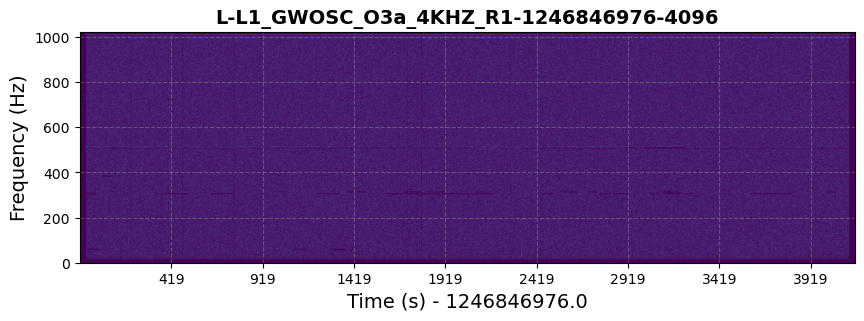

In [10]:
# Time-frequency plot (spectrogram) of the strain data
fig, ax = plt.subplots(figsize=(10,3))
trigObj.specgram(ax=ax);

In [11]:
# The collected triggers have the following shape: n_triggers x n_keys
print(trigObj.processedclist.shape)

# The last column contains the following properties:
trigObj.processedclist_keys
# the missing indices are just iterations of the index before
#  e.g., 4: 'hole_correction_33', 12: 'Im(SNR_44)', 14: 'calpha_1'

# These triggers are directly read from the saved .npy file

(92896, 15)


{'Description': 'processedclist stores properties of collected triggers in the following format',
 0: 'time',
 1: 'incoherent_SNRsq',
 2: 'normfac_22',
 3: 'hole_correction_22',
 6: 'psd_drift_correction',
 7: 'Re(SNR_22)',
 8: 'Im(SNR_22)',
 9: 'Re(SNR_33)',
 10: 'Im(SNR_33)',
 13: 'calpha_0'}

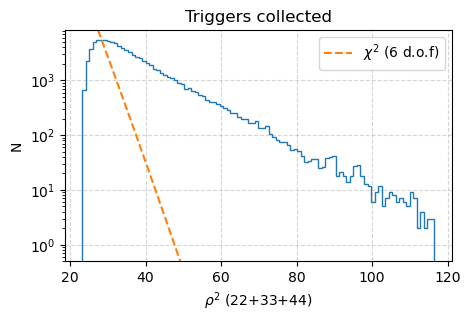

In [16]:
triglist = trigObj.processedclist
scores = triglist[:,1]
val,bins,_ = plt.hist(scores,log=True, bins=100, histtype='step')
bincent = utils.bincent(bins)

# Providing 6 d.o.f chi2 distribution (dashed) for comparison
plt.plot(bincent,stats.chi2.pdf(bincent,6)/stats.chi2.pdf(bincent[5],6)*val[5],
          ls='--', label=r'$\chi^2$ (6 d.o.f)')
plt.legend(); plt.ylim(0.5,np.amax(val)*1.5);
plt.ylabel('N'); plt.xlabel(r'$\rho^2$ (22+33+44)'); plt.title('Triggers collected');

# High mass banks in particular are quite glitchy
# as triggers are overproduced compared to Gaussian noise

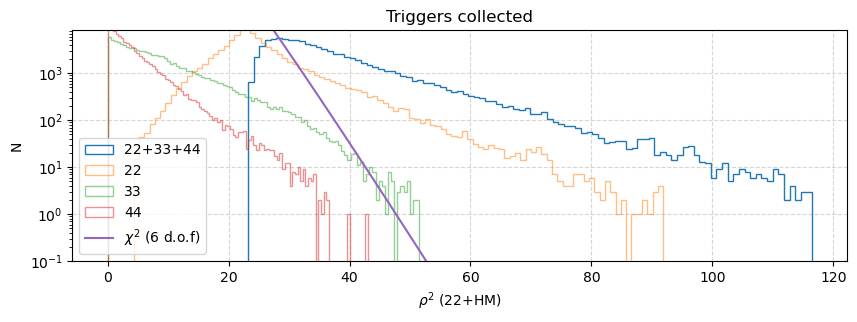

In [17]:
plt.figure(figsize=(10,3))
triglist = trigObj.processedclist
scores = triglist[:,1] # see trigger_single_detector_HM.py process_clist function for the different columns
val,bins,_ = plt.hist(scores,log=True, bins=100, histtype='step', label='22+33+44')
bincent = utils.bincent(bins)
plt.ylim(0.1,np.amax(val)*1.5);
plt.hist(triglist[:,trigObj.rezpos]**2+triglist[:,trigObj.imzpos]**2,log=True,
          bins=100, histtype='step', label='22', alpha=0.5)
plt.hist(triglist[:,trigObj.rezpos+2]**2+triglist[:,trigObj.imzpos+2]**2,log=True,
          bins=100, histtype='step', label='33', alpha=0.5)
plt.hist(triglist[:,trigObj.rezpos+4]**2+triglist[:,trigObj.imzpos+4]**2,log=True,
          bins=100, histtype='step', label='44', alpha=0.5)
plt.plot(bincent,stats.chi2.pdf(bincent,6)/stats.chi2.pdf(bincent[5],6)*val[5],
          label=r'$\chi^2$ (6 d.o.f)')
plt.ylabel('N'); plt.xlabel(r'$\rho^2$ (22+HM)'); plt.title('Triggers collected');
plt.legend(loc=3);

In [18]:
# Collecting all the triggers with SNRsq>50 and maximizing them over a 0.1s interval
mask = scores>50
loud_list = utils.splitarray(triglist[mask],triglist[mask,0],interval=0.1)
loud_list_max = np.array([x[np.argmax(x[:,1])] for x in loud_list])
len(loud_list)

12

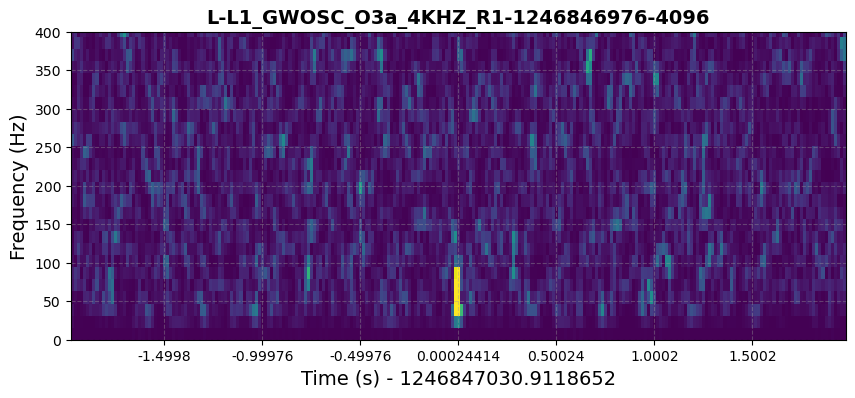

In [19]:
# Looking at a particular candidate with index 'ind'
ind=0
plot_time = 2
t_loud = loud_list_max[ind,0]

fig, ax = plt.subplots(figsize=(10,4))
trigObj.specgram(t0=t_loud, tmin = -plot_time, tmax=plot_time, nfft=128, noverlap=96, ax=ax)
ax.set_ylim(top=400);

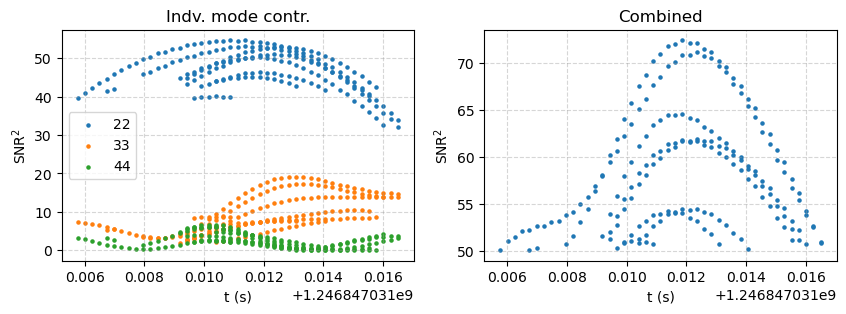

In [20]:
# Looking at the SNRsq contribution from each mode
plt.figure(figsize=(10,3))
zsq_list = np.c_[loud_list[ind][:,7]**2+loud_list[ind][:,8]**2,
                 loud_list[ind][:,9]**2+loud_list[ind][:,10]**2,
                 loud_list[ind][:,11]**2+loud_list[ind][:,12]**2]

plt.subplot(121)
plt.scatter(loud_list[ind][:,0],zsq_list[:,0], s=5, label='22')
plt.scatter(loud_list[ind][:,0],zsq_list[:,1],color='C1', s=5, label='33')
plt.scatter(loud_list[ind][:,0],zsq_list[:,2],color='C2', s=5, label='44')
plt.legend(); plt.title('Indv. mode contr.')
plt.xlabel('t (s)'); plt.ylabel('SNR$^2$')

plt.subplot(122)
plt.scatter(loud_list[ind][:,0],loud_list[ind][:,1], s=5)
plt.xlabel('t (s)'); plt.ylabel('SNR$^2$'); plt.title('Combined');

# Different lines with the same color represent different templates

### Individual injection in a particular file

In [21]:
# The downloaded LVK data is sampled at 1/4096 s so make finer frequency grid
fac = 4096*trigObj.dt
fs_fine = np.fft.rfftfreq(int(trigObj.fftsize * fac), d=1/4096.)

In [46]:
# This cell is used to set parameters of the injection

par_dic = {
    'd_luminosity': 1.0,
    'f_ref': 50.0,
    'iota': 1.0,
    'l1': 0.0,
    'l2': 0.0,
    'm1': 280,
    'm2': 70,
    's1x': 0.000,
    's1y': 0.0,
    's1z': -0.24,
    's2x': 0.000,
    's2y': 0.0,
    's2z': -0.2,
    'phi_ref': 0.0}

# For the injection parameters corresponding to a particular bank,
# one could use pars_test_bank from 'Test effectualness' section in TB notebook
# or directly load one set of params from the bank

# input_pars = np.load(os.path.join(tbp.wf_DIR,'pars_samples.npy'))
# bank_ids = np.load(os.path.join(tbp.wf_DIR,'bank_ids.npy'))
# input_pars[bank_ids==ib][20]
# _ = [204.17536932,  33.27181538,  -0.36476979,  -0.37293192]
# par_dic['m1'] = _[0]; par_dic['m2'] = _[1]; par_dic['s1z'] = _[2]; par_dic['s2z'] = _[3]

bank = tg.TemplateBank.from_json(
    os.path.join(tbp.DIR,f'BBH_{ib}/bank_{isb}/metadata.json'))
par_dic['m1'], par_dic['m2'], par_dic['s1z'], par_dic['s2z'] = bank.pars[40][:4]

In [47]:
wf_fd = np.nan_to_num(tg.compute_hplus_hcross(fs_fine, par_dic, 'IMRPhenomXHM',
                                [(2,2), (3,3), (4,4), (2,-2), (3,-3), (4,-4)])[0])
wf_td = utils.IRFFT(wf_fd)/trigObj.dt*2

coeffs = utils.band_filter(dt = trigObj.dt/2, fmin=20)
wf_filt = signal.sosfiltfilt(coeffs[0],np.fft.fftshift(wf_td),padlen=coeffs[1])

# Make wf_filt have a particular SNR
inj_SNR = 15
fac_SNR = inj_SNR/np.sqrt(np.sum(np.abs(wf_fd**2)/\
                                 (trigObj.asdfunc(fs_fine)**2) * 4 *np.diff(fs_fine)[0]))
wf_filt *= fac_SNR

In [48]:
# Computing SNR^2 in individual orthogonalized modes
wfs = np.zeros((3,len(trigObj.templatebank.fs_fft)),dtype='complex128')
wfs[0] =np.nan_to_num(tg.compute_hplus_hcross(trigObj.templatebank.fs_fft,
                                               par_dic, 'IMRPhenomXAS',[(2, 2)])[0])
wfs[1] =np.nan_to_num(tg.compute_hplus_hcross(trigObj.templatebank.fs_fft,
                                               par_dic, 'IMRPhenomXHM',[(3, 3), (3, -3)])[0])
wfs[2] =np.nan_to_num(tg.compute_hplus_hcross(trigObj.templatebank.fs_fft,
                                               par_dic, 'IMRPhenomXHM',[(4, 4), (4, -4)])[0])
wf_full =np.nan_to_num(tg.compute_hplus_hcross(trigObj.templatebank.fs_fft, 
            par_dic, 'IMRPhenomXHM',[(2, 2),(3, 3),(4, 4),(2, -2),(3, -3),(4, -4)])[0])
weights =  4 *np.diff(trigObj.templatebank.fs_fft)[0]\
    /(trigObj.asdfunc(trigObj.templatebank.fs_fft)**2)
full_CovMat = np.zeros((3,3),dtype = 'complex128')
        
for (j,k) in np.array(np.triu_indices(3)).T:
    full_CovMat[j,k] = np.sum( weights * wfs[j] * np.conj(wfs[k]), axis=-1)

full_CovMat[np.tril_indices(3)] = full_CovMat.T.conj()[np.tril_indices(3)]
L = np.linalg.cholesky( np.linalg.inv(full_CovMat) )
wfs = np.dot( L.conj().T, wfs)
wfs = (wfs.T / np.sqrt(np.sum(weights * wfs * np.conj(wfs) ,axis=-1))).T
snr22 = np.sum( weights* wf_full* np.conj(wfs[0]), axis=-1); snr22=np.abs(snr22*fac_SNR)**2
snr33 = np.sum( weights* wf_full* np.conj(wfs[1]), axis=-1); snr33=np.abs(snr33*fac_SNR)**2
snr44 = np.sum( weights* wf_full* np.conj(wfs[2]), axis=-1); snr44=np.abs(snr44*fac_SNR)**2
snr22, snr33, snr44

(191.4402538424093, 29.163070131505734, 4.396676026084961)

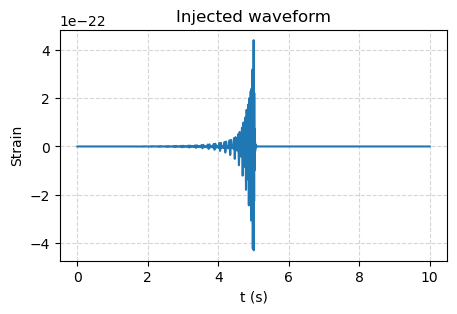

In [49]:
# Full length of the injected wf, having zeros at the end is okay
inj_length = 10
wf_filt_inject = np.fft.fftshift(utils.change_filter_times_td(
                    np.fft.ifftshift(wf_filt),len(wf_filt), inj_length*4096)) 
# utils.change_filter_times_td cuts the waveform, ideally use greater than trigObj.templatebank.support_whitened_wf

plt.plot(np.arange(len(wf_filt_inject))/4096,wf_filt_inject);
plt.xlabel('t (s)'); plt.ylabel('Strain'); plt.title('Injected waveform');

In [ ]:
# Check if the area we want to inject in is empty

# Time of the injection
t_inj = (trigObj.time[0]+trigObj.time[-1])/2

plot_time = 2
fig, ax = plt.subplots(figsize=(10,4))
trigObj.specgram(t0=t_inj, tmin = -plot_time, tmax=plot_time, nfft=128, noverlap=96, ax=ax)
ax.set_ylim(top=300);

In [51]:
# Code for injection at t_inj

# Make a sub-directory which we will use for injections
output_dir_inj = os.path.join(output_dir, 'Injections')
os.makedirs(output_dir_inj, exist_ok=True)
print('Output directory for injections:', output_dir_inj)

# tgps file
fname = os.path.join(utils.STRAIN_ROOT[run], detector,
            f'{detector[0]}-{detector}_GWOSC_{run}_4KHZ_R1-{file_ind}-4096.hdf5')

# Preprocessing the file
out_files = triggering_on_cluster.filelist(fname=fname, output_dir=output_dir_inj)
left_fname, right_fname = utils.get_left_right_fnames(fname)
try: os.remove(out_files[3]); os.remove(out_files[4]); os.remove(out_files[5])
except: pass
trigObj = trig.TriggerList(fname = fname,
             left_fname=left_fname,
             right_fname=right_fname,
             template_conf = \
               os.path.join(tbp.DIR,f"BBH_{ib}/bank_{isb}/metadata.json"),
             fname_preprocessing = out_files[5],
             delta_calpha = tbp.delta_calpha[f'BBH_{ib}'],
             injection_args={'time':t_inj+inj_length/2, 'type':'wf','inj_pars':[wf_filt_inject]} 
            # We use the injected wf here ('time' corresponds to the right edge of the waveform)
            # so we shift t_inj accordingly
             )

# Generating triggers by convolving with templates in templatebank
trigObj.gen_triggers(trig_fname=out_files[3], ncores=ncores, marginalized_score_HM = True)
trigObj.to_json(out_files[4])

# checking if the whitened injected wf gives SNR close to inj_SNR
print('SNR of injected waveform:', np.linalg.norm(trigObj.injected_wf_whitened))

Saving 71231 new candidates
SNR of injected waveform: 14.89364547511786


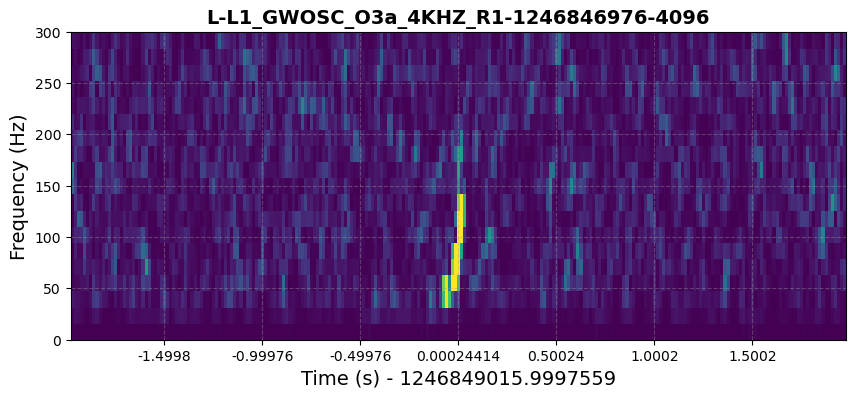

In [56]:
# Check if the injection is seen in specgram (didn't got holed)

plot_time = 2
fig, ax = plt.subplots(figsize=(10,4))
# t_inj corresponds to right edge the injected waveform data shown earlier,
# so we shift the time accordingly
trigObj.specgram(t0=t_inj, tmin = -plot_time, tmax=plot_time, nfft=128, noverlap=96, ax=ax)
ax.set_ylim(top=300);

In [57]:
# Collecting all the triggers with SNRsq>50 and maximizing them over a 0.1s interval
mask = triglist = trigObj.processedclist[:,1]>50
loud_list = utils.splitarray(trigObj.processedclist[mask],
                             trigObj.processedclist[mask,0],interval=0.1)
loud_list_max = np.array([x[np.argmax(x[:,1])] for x in loud_list])
len(loud_list)

14

In [58]:
print('SNRsq of injected waveform:', np.linalg.norm(trigObj.injected_wf_whitened)**2)

print('Time differences, indices and SNR of the triggers <1 sec away from the injection:')
mask = np.abs(loud_list_max[:,0]-t_inj)<1
np.abs(loud_list_max[:,0]-t_inj)[mask], np.arange(len(mask))[mask], loud_list_max[mask,1]

# Note that the injection SNR need not be exactly recovered as the noise typically
# causes +/- 1 sigma fluctuations in the SNR

SNRsq of injected waveform: 221.82067553849873
Time differences, indices and SNR of the triggers <1 sec away from the injection:


(array([0.00634766, 0.00976562]),
 array([8, 9]),
 array([244.77695919, 167.21745733]))

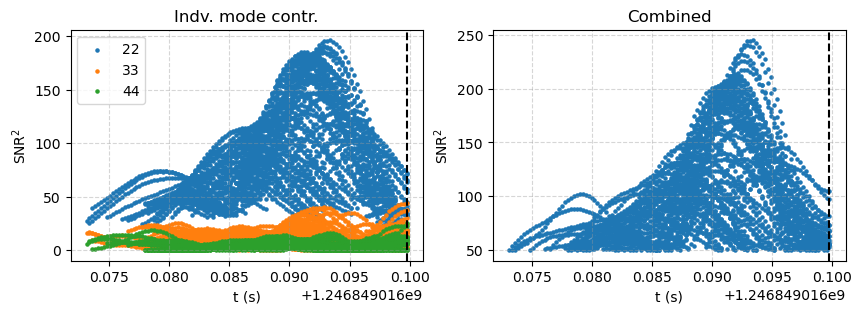

In [59]:
# The injected trigger is shown in the dashed black line
# it can be a bit offset from the peak as t_inj corresponds to the maximum
# of the injected waveform, while the recovered time is where the
# signal is linear free

ind=8

# Looking at the SNRsq contribution from each mode
plt.figure(figsize=(10,3))
zsq_list = np.c_[loud_list[ind][:,7]**2+loud_list[ind][:,8]**2,
                 loud_list[ind][:,9]**2+loud_list[ind][:,10]**2,
                 loud_list[ind][:,11]**2+loud_list[ind][:,12]**2]

plt.subplot(121)
plt.scatter(loud_list[ind][:,0],zsq_list[:,0], s=5, label='22')
plt.scatter(loud_list[ind][:,0],zsq_list[:,1],color='C1', s=5, label='33')
plt.scatter(loud_list[ind][:,0],zsq_list[:,2],color='C2', s=5, label='44')
plt.legend(); plt.title('Indv. mode contr.')
plt.xlabel('t (s)'); plt.ylabel('SNR$^2$')
plt.axvline(t_inj, ls='--', color='k');

plt.subplot(122)
plt.scatter(loud_list[ind][:,0],loud_list[ind][:,1], s=5)
plt.xlabel('t (s)'); plt.ylabel('SNR$^2$'); plt.title('Combined');
plt.axvline(t_inj, ls='--', color='k');

# Different dotted lines with the same color represent different templates

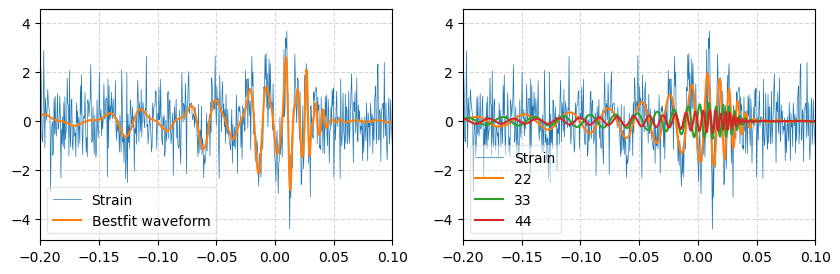

In [60]:
plt.figure(figsize=(10,3))
plt.subplot(121)
ax = plt.gca();
trigObj.plot_bestfit_waveform(loud_list_max[ind], ax=ax)
plt.xlim(left=-0.2,right=0.1)
plt.subplot(122)
ax = plt.gca();
trigObj.plot_bestfit_waveform(loud_list_max[ind], individual_modes=True, ax=ax)
plt.xlim(left=-0.2,right=0.1);

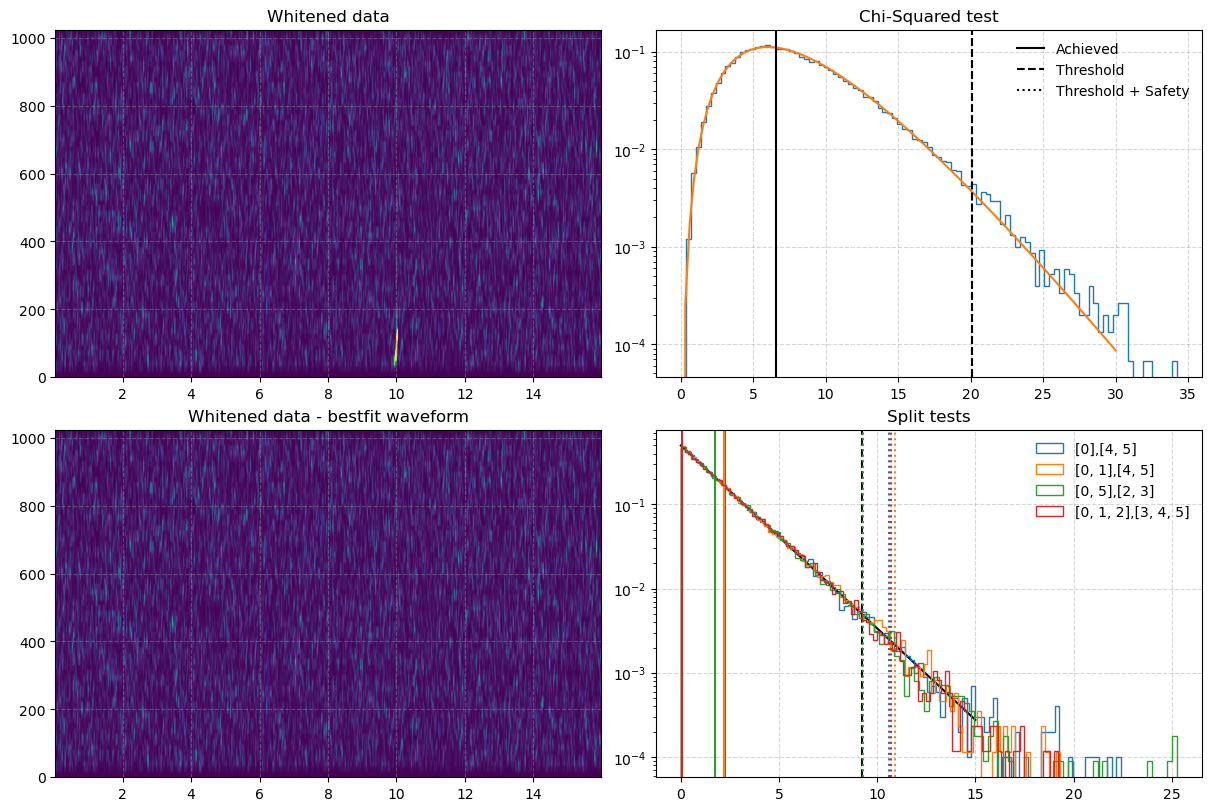

In [61]:
# Check if the injection got vetoed
utils.plot_veto_details(trigObj, loud_list_max[ind], use_HM=True);

# The solid lines should be lower than the dotted ones on the right panels,
# otherwise the candidate is vetoed

# 2. Coincidence on individual files

In [62]:
# The main python file associated with this section is coincidence_HM.py
import coincidence_HM as coin

# Cogwheel is used currently for preparing coincident injections
# and for our coherent ranking statistic

# cogwheel can be found in https://github.com/jroulet/cogwheel
# and installed using conda:
# conda install -c conda-forge cogwheel-pe

# Or it can be locally downloaded and imported as a module
# sys.path.insert(-1,"/data/jayw/IAS/GW/cogwheel") # CHANGE path

### 2.1. Preparing coincident injections

In [90]:
# Here we will do a coincident injection and then run coincidence on it to see if
# the coincidence code is working properly

In [101]:
ib=14; isb=0
detector = 'L1'
run = 'O3a'
file_ind = 1246846976

In [111]:
output_dir_inj = os.path.join(output_dir, 'Injections',f'BBH_{ib}_bank_{isb}')
os.makedirs(output_dir_inj, exist_ok=True)

In [103]:
# Get the injection time from the trigger object saved in the previous section
trigObj = trig.TriggerList.from_json(os.path.join(output_dir,
            f'{detector[0]}-{detector}_GWOSC_{run}_4KHZ_R1-{file_ind}-4096_config.json'))
t_inj = (trigObj.time[0]+trigObj.time[-1])/2

# If one has already done triggering on all files, one could use the following
# triggers_dir = f'/data/jayw/IAS/GW/Data/HM_{run}_search/OutputDir'
# fpath = f'/data/jayw/IAS/GW/Data/HM_O3a_search/OutputDir/BBH_{ib}_bank_{isb}/{detector[0]}-{detector}_GWOSC_{run}_4KHZ_R1-{file_ind}-4096_config.json'
# trigObj = trig.TriggerList.from_json(fpath)
# t_inject = (trigObj.time[0] + trigObj.time[-1])/2.

In [105]:
# Writing a reference par_dic for cogwheel and generating parameters for the injected wf

par_dic = {
    'd_luminosity': 1000,
    'f_ref': 50.0,
    'iota': 1.0,
    'l1': 0.0,
    'l2': 0.0,
    'm1': 284.6992591,
    'm2': 32.7,
    's1x_n': 0.000,
    's1y_n': 0.0,
    's1z': -0.12,
    's2x_n': 0.000,
    's2y_n': 0.0,
    's2z': -0.31,
    'phi_ref': 0.0,
    'ra': 3,
    'dec':1,
    't_geocenter':0,
    'psi':0}

bank = tg.TemplateBank.from_json(
    os.path.join(tbp.DIR,f'BBH_{ib}/bank_{isb}/metadata.json'))
par_dic['m1'], par_dic['m2'], par_dic['s1z'], par_dic['s2z'] = bank.pars[40][:4]

In [106]:
# Generating the multi-detector injected waveform from cogwheel

from cogwheel import waveform
wf_generator = waveform.WaveformGenerator(detector_names = 'HL',
                                tgps = t_inj, tcoarse=0, approximant='IMRPhenomXPHM')

In [107]:
fs_fine = np.fft.rfftfreq(128*4096, d=1/4096.)
wf_fd = wf_generator.get_strain_at_detectors(fs_fine , par_dic) # H and L
wf_td = utils.IRFFT(wf_fd)*4096.
coeffs = utils.band_filter(dt = 1/4096., fmin=20)
wf_filt = signal.sosfiltfilt(coeffs[0], np.fft.fftshift(wf_td, axes=-1), padlen=coeffs[1])

# Make wf_filt in the louder detector have a particular SNR
SNR = 12
fac_SNR = SNR/np.sqrt(np.sum(
    np.abs(wf_fd**2)/(trigObj.asdfunc(fs_fine)**2) * 4 *np.diff(fs_fine)[0], axis=-1))
wf_filt *= np.amin(fac_SNR)

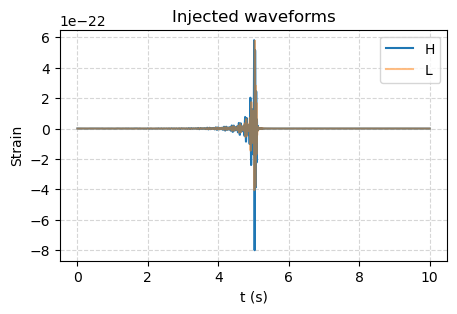

In [108]:
inj_length = 10 # in sec 
wf_filt_inject = np.fft.fftshift(utils.change_filter_times_td(
            np.fft.ifftshift(wf_filt, axes=-1),len(wf_filt[0]), inj_length*4096), axes=-1)
plt.plot(np.arange(len(wf_filt_inject[0]))/4096., wf_filt_inject[0], label='H')
plt.plot(np.arange(len(wf_filt_inject[0]))/4096., wf_filt_inject[1], alpha=0.5, label='L')
plt.legend(); plt.xlabel('t (s)'); plt.ylabel('Strain'); plt.title('Injected waveforms');

In [ ]:
# Injecting into the data segment, running data-preprocessing and triggering
# for both H and L

for ind, detector in enumerate(['H1','L1']):
    # tgps file
    fname = os.path.join(utils.STRAIN_ROOT[run], detector,
            f'{detector[0]}-{detector}_GWOSC_{run}_4KHZ_R1-{file_ind}-4096.hdf5')
    out_files = triggering_on_cluster.filelist(fname=fname,
                                    output_dir=output_dir_inj)
    left_fname, right_fname = utils.get_left_right_fnames(fname)
    try: os.remove(out_files[3]); os.remove(out_files[4]); os.remove(out_files[5]);
    except: pass
    trigObj = trig.TriggerList(fname = fname,
                 left_fname=left_fname,
                 right_fname=right_fname,
                 template_conf = \
                    os.path.join(tbp.DIR,f"BBH_{ib}/bank_{isb}/metadata.json"),
                 fname_preprocessing = out_files[5],
                 delta_calpha = tbp.delta_calpha[f'BBH_{ib}'],
                 # We use the injected wf here
                 injection_args={'time':t_inj+inj_length/2,
                                  'type':'wf','inj_pars':[wf_filt_inject[ind]]}
                 )

    # Generating triggers by convolving with templates in templatebank
    trigObj.gen_triggers(trig_fname=out_files[3], ncores=ncores)
    trigObj.to_json(out_files[4])

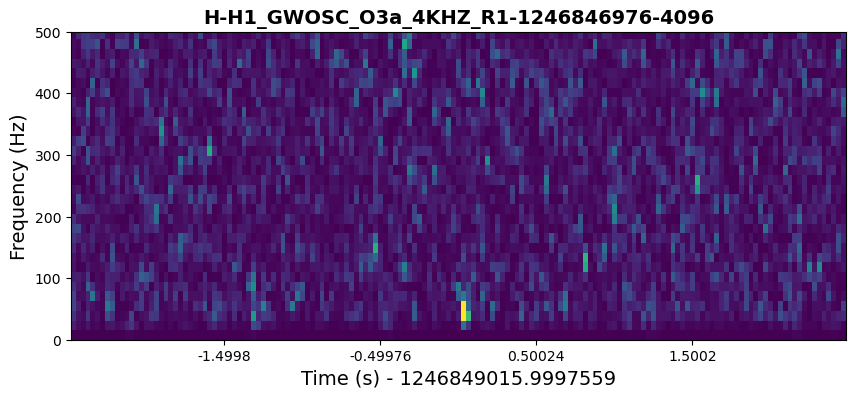

In [141]:
# Again inspecting if the event shows up in the spectrogram of a particular detector
detector = 'H1'

fpath = os.path.join(output_dir_inj,
                     f'{detector[0]}-{detector}_GWOSC_O3a_4KHZ_R1-{file_ind}-4096_config.json')
trigObj = trig.TriggerList.from_json(fpath)

plot_time=2.5
fig, ax = plt.subplots(figsize=(10,4))
trigObj.specgram(t0=t_inj, tmin = -plot_time, tmax=plot_time, nfft=128, noverlap=64, ax=ax)
ax.set_ylim(top=500);

In [143]:
# Collecting all the triggers with SNRsq>50 and maximizing them over a 0.1s interval
print('SNRsq of injected waveform:', np.linalg.norm(trigObj.injected_wf_whitened)**2)

mask = triglist = trigObj.processedclist[:,1]>50
loud_list = utils.splitarray(trigObj.processedclist[mask],
                             trigObj.processedclist[mask,0],interval=0.1)
loud_list_max = np.array([x[np.argmax(x[:,1])] for x in loud_list])

print("Time differences, indices and SNR of the trigger closest to the injection:")
mask = np.abs(loud_list_max[:,0]-t_inj)<1
np.abs(loud_list_max[:,0]-t_inj)[mask], np.arange(len(mask))[mask], loud_list_max[mask,1]

# Note that the injection SNR need not be exactly recovered as the noise typically
# causes +/- 1 sigma fluctuations in the SNR

SNRsq of injected waveform: 66.04184887908923
Time differences, indices and SNR of the trigger closest to the injection:


(array([0.0546875]), array([0]), array([88.0249365]))

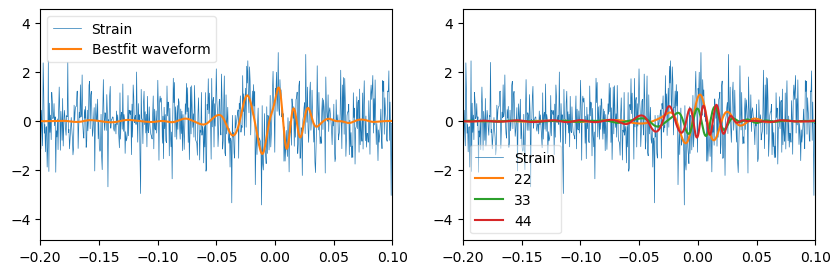

In [140]:
# Comparing the best-fit waveform for a particular trigger with data

ind = 20 # copy from the above cell
plt.figure(figsize=(10,3))
plt.subplot(121)
ax = plt.gca();
trigObj.plot_bestfit_waveform(loud_list_max[ind], ax=ax)
plt.xlim(left=-0.2,right=0.1)
plt.subplot(122)
ax = plt.gca();
trigObj.plot_bestfit_waveform(loud_list_max[ind], individual_modes=True, ax=ax)
plt.xlim(left=-0.2,right=0.1);

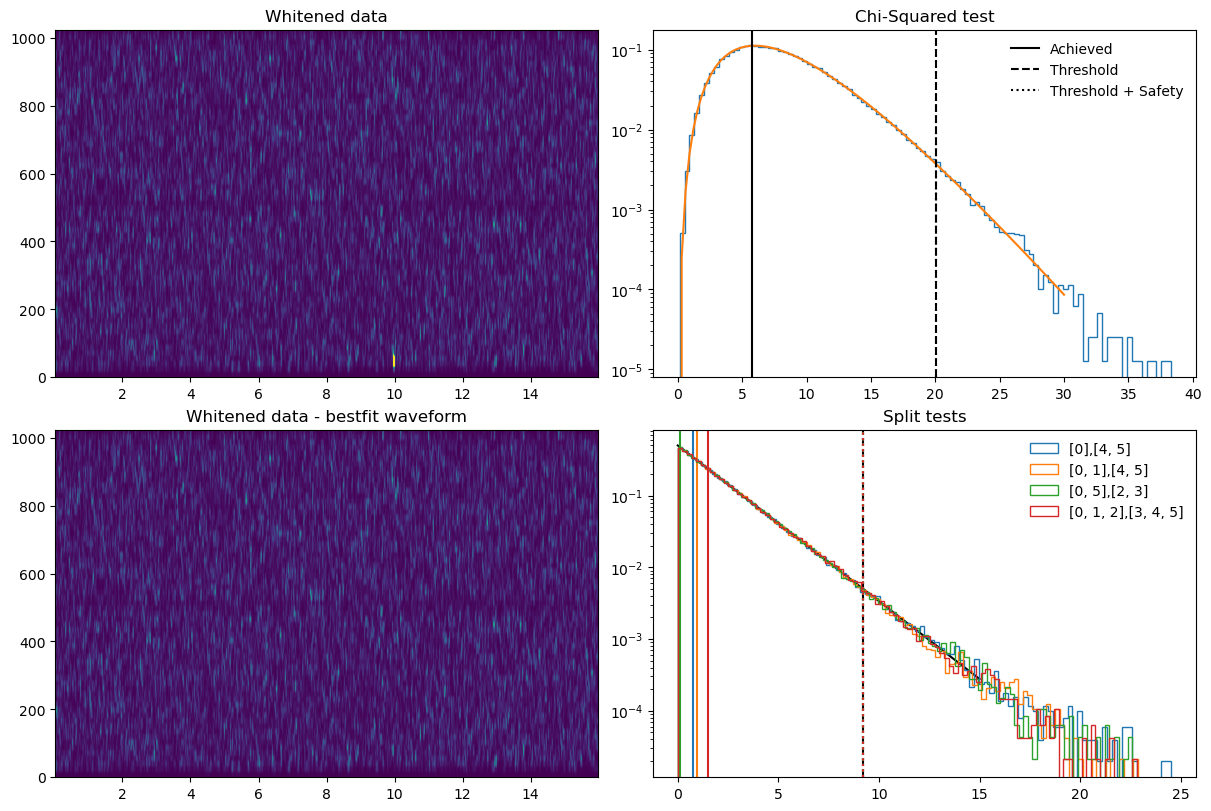

In [129]:
utils.plot_veto_details(trigObj, loud_list_max[ind], use_HM=True);

# The solid lines should be to the left of the dotted ones on the right panels,
# otherwise the candidate is vetoed

### 2.2. Running coincidence on generated files

In [ ]:
ib=14; isb=0
output_dir_inj = os.path.join(output_dir, 'Injections',f'BBH_{ib}_bank_{isb}')

# All the outputs will be stored to this file
out_fname = os.path.join(
    output_dir_inj,f'coincident_events__H1_L1_{file_ind}_{file_ind}.npz')

if os.path.exists(out_fname):
    raise RuntimeWarning(f'File {out_fname} already exists.\
                          Remove it else code does not run.')

candidates = coin.find_interesting_dir(output_dir_inj,
                                            n_cores=ncores, min_veto_chi2=30,
                                            out_fname=out_fname)
# If you do not want to run vetoes, set a high threshold for them,
# e.g., min_veto_chi2=1e6

In [ ]:
# If you want to rather run the above code on a separate terminal
# copy paste the following code snippet on a terminal window
# replacing the output_dir_inj from the above cell
# (this cell hangs on a jupyter notebook for some reason)

# import os, sys
# sys.path.insert(0,"/data/jayw/IAS/GW/gw_detection_ias")
# import coincidence_HM as coin

# ib=14; isb=0
# output_dir_inj = f'/data/jayw/IAS/GW/Trash/Delete/Triggering/Injections/BBH_{ib}_bank_{isb}'
# coin.find_interesting_dir_cluster(output_dir_inj, output_dir=output_dir_inj+'cand0',
#     output_timeseries=True, output_coherent_score=True,
#     cluster=None, submit=True, n_cores=10, run='O3a',
#     threshold_chi2=60, 
#     min_veto_chi2=30)

In [130]:
# Loading the saved file and outputting the stored entries and their shapes
cand_output = np.load(os.path.join(
    output_dir_inj,f'coincident_events__H1_L1_{file_ind}_{file_ind}.npz'),allow_pickle=True)

for file in cand_output.files:
    print(file+':', cand_output[file].shape)
    
# candidates: n_candidates x detector x pclist_elements array (background+coincidence)

candidates: (22, 2, 15)
mask_vetoed: (22,)
metadata: (22, 2, 46)
metadata_keys: (46,)
detectors: (2,)
timeseries: (22, 2)
coherent_scores: (22,)


In [ ]:
# List of veto tests that we deployed (just for reference)
cand_output['metadata_keys']

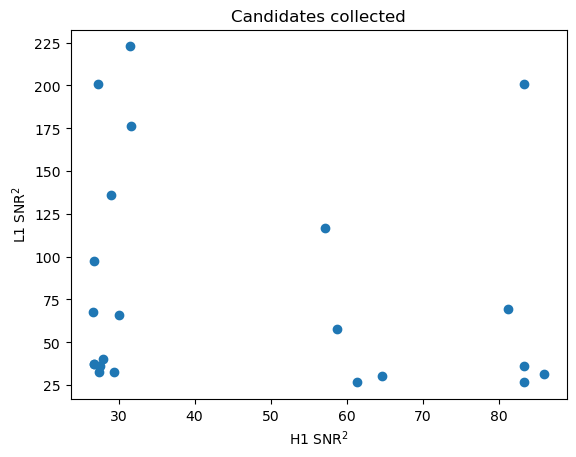

In [131]:
candidates = cand_output['candidates']
plt.scatter(candidates[:,0,1], candidates[:,1,1])
plt.xlabel('H1 SNR$^2$'); plt.ylabel('L1 SNR$^2$');
plt.title('Candidates collected');

In [134]:
candidates = cand_output['candidates']
# Removing vetoed candidates
candidates = candidates[cand_output['mask_vetoed']]
# Collecting coincident triggers (as opposed to background triggers)
mask_coin = np.abs(candidates[:,0,0]-candidates[:,1,0])<0.2
candidates = candidates[mask_coin]
# np.amin(np.abs(triggers[:,0,0]-triggers[:,1,0])), np.argmin(np.abs(triggers[:,0,0]-triggers[:,1,0]))

In [136]:
# Time differences, indices, and H,L SNR^2 of the trigger closest to the injection
mask = np.abs(candidates[:,0,0]-t_inj)<1
np.abs(candidates[:,0,0]-t_inj)[mask], np.arange(len(mask))[mask], candidates[mask,:,1]

# The chosen coincident trigger may not be the one with the highest SNRsq.
# It is the one with the best marginalized scores after taking into account
# the prior of HM ratios and the astrophysical prior on the 22 waveform

(array([0.03564453]), array([0]), array([[81.23091328, 69.60438974]]))

# Extras

In [ ]:
# Please ignore this section

## Debugging triggering

In [ ]:
# once triggering is done, one can look at the output files

In [15]:
utils.OUTPUT_DIR

defaultdict(<function utils.<lambda>()>,
            {'o3a': '/scratch/lustre/tejaswi/GW/OutputDir',
             'O3a': '/scratch/lustre/tejaswi/GW/OutputDir',
             'o3b': '/scratch/lustre/srolsen/GW/OutputDir',
             'O3b': '/scratch/lustre/srolsen/GW/OutputDir',
             'hm_o3a': '/data/jayw/IAS/GW/Data/HM_O3a_search/Triggers_single_det',
             'hm_o3b': '/data/jayw/IAS/GW/Data/HM_O3b_search/Triggers_single_det'})

In [32]:
run = 'O3a'
triggers_dir = f'/data/jayw/IAS/GW/Data/HM_{run}_search/Triggers_single_det'

In [33]:
# Get tgps filenames corresponding to triggers
# def get_detector_fnames(time, dname, detector, return_times=False):
#     t0 = utils.TMIN + int(np.floor((time - utils.TMIN) / 4096)) * 4096
#     if return_times: return t0
#     fname = os.path.join(dname,f'{detector[0]}-{detector[0]}1_GWOSC_O3b_4KHZ_R1-{t0}-4096_config.json')
#     if os.path.exists(fname): return(fname, True)
#     else: 
#         print(f'{fname} not found')
#         return (t0, False)
    
# tgps_event = 1249034891.949707
# get_detector_fnames(tgps_event, dname, detector)

In [34]:
ib=9; isb=0
detector = 'H1'
dname = os.path.join(triggers_dir,f'BBH_{ib}_bank_{isb}')
file_ind = 1250574336
# Sample file: O3a:1250574336 O3b:1269358592

In [35]:
fpath = os.path.join(dname, f'{detector[0]}-{detector}_GWOSC_{run}_4KHZ_R1-{file_ind}-4096_config.json')
trigObj = trig.TriggerList.from_json(fpath)
# trigObj = trig.TriggerList.from_json(fpath,load_data=True, do_signal_processing=False)

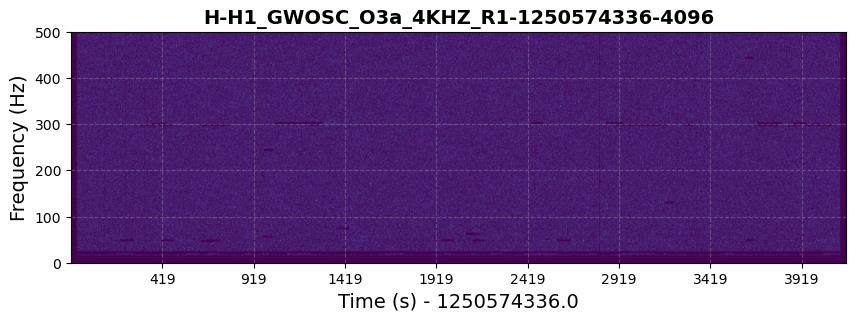

In [8]:
fig, ax = plt.subplots(figsize=(10,3))
trigObj.specgram(ax=ax);
ax.set_ylim(top=500);

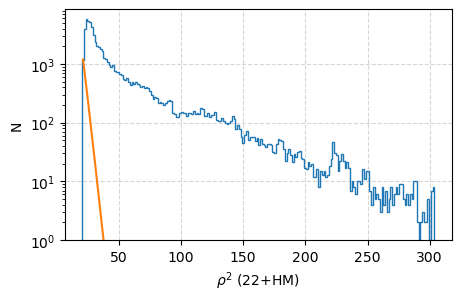

In [ ]:
triglist = trigObj.processedclist
val , bins, _ = plt.hist(triglist[:,1],log=True, bins=200,histtype='step')
plt.ylabel('N'); plt.xlabel(r'$\rho^2$ (22+HM)'); #plt.title('Triggers');
bincent = utils.bincent(bins)
plt.plot(bincent,stats.chi2.pdf(bincent,6)/stats.chi2.pdf(bincent[0],6)*val[0])
plt.ylim(1,1.5*np.amax(val));

In [ ]:
mask = triglist[:,1]>50
loud_list = utils.splitarray(triglist[mask],triglist[mask,0],interval=1)
glitchlist = np.array([x[np.argmax(x[:,1])] for x in loud_list]) # Max of glitches within banks
len(loud_list), glitchlist[:,1]

(18,
 array([ 80.39255626,  55.53444786, 303.8574021 ,  75.53767022,
        277.91673037,  53.98105724, 144.15722414, 133.16162485,
         73.14796465,  61.92713816,  52.24591512, 222.6983468 ,
        289.04107641, 164.5185168 ,  57.34951395, 133.68682753,
         50.59988323,  60.69616461]))

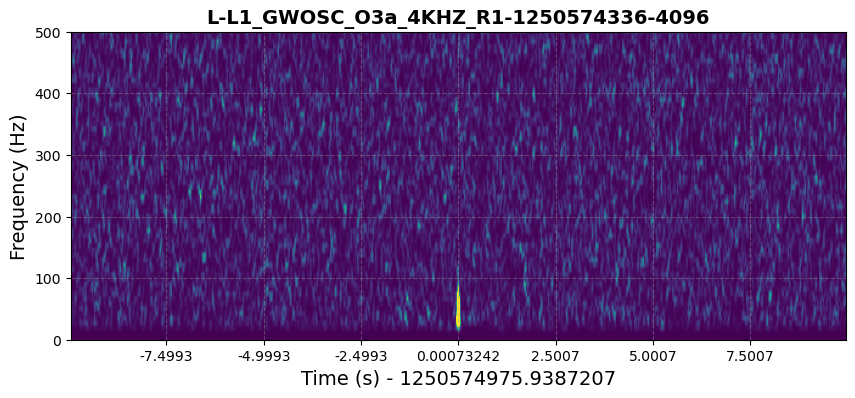

In [ ]:
ind=2
plot_time = 10
# tglitch = tcenter - 2.5 # checking injection

tglitch = glitchlist[ind,0]
fig, ax = plt.subplots(figsize=(10,4))
trigObj.specgram(t0=tglitch, tmin = -plot_time, tmax=plot_time, nfft=128, noverlap=96, ax=ax)
ax.set_ylim(top=500);

Text(0, 0.5, 'SNR$^2$')

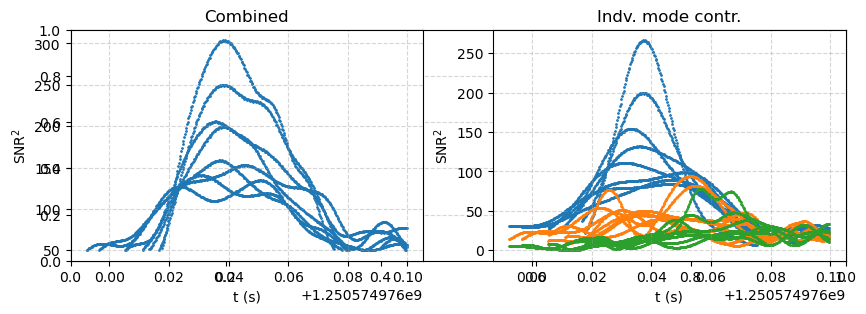

In [ ]:
# in progress
plt.figure(figsize=(10,3))
plt.grid(visible=True, which='major', color='#999999', linestyle='--',alpha=0.4)
zsq_list = np.c_[loud_list[ind][:,7]**2+loud_list[ind][:,8]**2, loud_list[ind][:,9]**2+loud_list[ind][:,10]**2, loud_list[ind][:,11]**2+loud_list[ind][:,12]**2]

# Toggle to use physical scores or not
physical_scores = zsq_list.copy()
# physical_scores = np.array([scores_physical(zsq_list[i], z44_quantiles, r_max) for i in range(len(zsq_list))])

plt.subplot(121)
plt.scatter(loud_list[ind][:,0],np.sum(physical_scores,axis=-1), s=1)
plt.xlabel('t (s)'); plt.ylabel('SNR$^2$'); plt.title('Combined');

plt.subplot(122)
plt.scatter(loud_list[ind][:,0],physical_scores[:,0], s=1)
plt.scatter(loud_list[ind][:,0],physical_scores[:,1],color='C1', s=1)
plt.scatter(loud_list[ind][:,0],physical_scores[:,2],color='C2', s=1)
# plt.axhline(snr22, color='C0',alpha=0.5); plt.axhline(snr33, color='C1',alpha=0.5); plt.axhline(snr44, color='C2',alpha=0.5)
plt.title('Indv. mode contr.')
plt.xlabel('t (s)'); plt.ylabel('SNR$^2$')

### Triggering codes

In [ ]:
# Cheap triggering code
fname = f'/data/bzackay/GW/O3a/{detector}/{detector[0]}-{detector}_GWOSC_O3a_4KHZ_R1-{file_ind}-4096.hdf5'
out_files = triggering_on_cluster.filelist(fname=fname,output_dir=trashdir)
left_fname, right_fname = utils.get_left_right_fnames(fname)
trigObj = trig.TriggerList(fname = fname,
             left_fname=left_fname,
             right_fname=right_fname,
             template_conf = f"/data/bzackay/GW/templates/O3_hm/Multibanks/BBH_{ib}/bank_{isb}/metadata.json",
                          do_ffts=1)


# trigObj.processedclist = None
# trigObj.prepare_for_triggers(average='safemean')
# # trigObj.psd_drift_correction = trigObj.gen_psd_drift_correction(calphas=[0,0],avg='safemean')
# trigObj.gen_triggers(delta_calpha=tbp.delta_calpha[f'BBH_{ib}'], marginalized_score_HM=True) #, trig_fname=out_files[3]
# # trigObj.fname_preprocessing = out_files[5]
# # trigObj.to_json(out_files[4])

In [ ]:
# More expensive code
fname = f'/data/bzackay/GW/O3a/{detector}/{detector[0]}-{detector}_GWOSC_O3a_4KHZ_R1-{file_ind}-4096.hdf5'
out_files = triggering_on_cluster.filelist(fname=fname,output_dir=trashdir)
left_fname, right_fname = utils.get_left_right_fnames(fname)
trigObj = trig.TriggerList(fname = fname,
             left_fname=left_fname,
             right_fname=right_fname,
             template_conf = f"/data/bzackay/GW/templates/O3_hm/Multibanks/BBH_{ib}/bank_{isb}/metadata.json",
                          do_ffts=2)

# trigObj.gen_triggers(delta_calpha=0.5, trig_fname=out_files[3], marginalized_score_HM=True)
# trigObj.to_json(out_files[4], preprocessing_fname=out_files[5])

### Testing gen_triggers_local function

In [ ]:
# Using relative binning should give a similar answer as FFT
# This function is only used in coincidence_HM.py

# There were a lot of subtle bugs we'd found when debugging this function
# so I made this section to do an explicit check

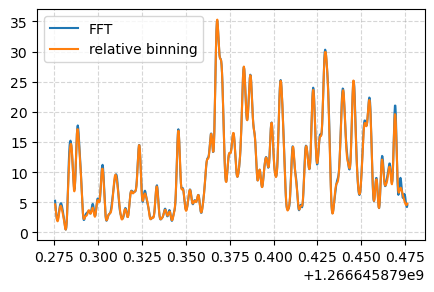

In [ ]:
trig_obj = trig.TriggerList.from_json(
    '/data/jayw/IAS/GW/Data/HM_O3b_search/OutputDir/BBH_1_bank_1/H-H1_GWOSC_O3b_4KHZ_R1-1266642944-4096_config.json')

trig_h1 = np.load('/data/jayw/IAS/GW/Trash/Delete/trig_h1.npy')

trigs = trig_obj.gen_triggers_local(
    trigger=trig_h1,
    dt_left= 0.1 - 0.0001220703125,
    dt_right= 0.1 + 0.0001220703125,
    compute_calphas=[trig_h1[trig_obj.c0_pos:]],
    apply_threshold=False, relative_binning=False,
    zero_pad=False, orthogonalize_modes=False)

trigs_RB = trig_obj.gen_triggers_local(
    trigger=trig_h1,
    dt_left= 0.1 - 0.0001220703125,
    dt_right= 0.1 + 0.0001220703125,
    compute_calphas=[trig_h1[trig_obj.c0_pos:]],
    apply_threshold=False, relative_binning=True,
    zero_pad=False, orthogonalize_modes=False)

plt.plot(trigs[:,0], trigs[:,1], label='FFT')
plt.plot(trigs_RB[:,0], trigs_RB[:,1], label='relative binning')
plt.legend()

## Debugging Coincidence

### Coherent score HM

In [16]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal
lal.swig_redirect_standard_output_error(False);

In [15]:
import coherent_score_hm_search as cs
from cogwheel.likelihood.marginalization import SkyDictionary

In [ ]:
# Running the notebook on terminal

# import os, sys
# sys.path.insert(0,"/data/jayw/IAS/GW/gw_detection_ias")
# import coincidence_HM as coin

# ib=14; isb=0
# dire= f'/data/jayw/IAS/GW/Data/Injections/Testing/BBH_{ib}_bank_{isb}'
# coin.find_interesting_dir_cluster(dire, output_dir=dire+'cand1',
#     output_timeseries=True, output_coherent_score=True,
#     cluster=None, submit=True, n_cores=10, run='O3a',
#     threshold_chi2=60, 
#     min_veto_chi2=30)

In [6]:
ib=14; isb=0
file_ind = 1250574336
# Most injections have 1250574336
run = 'O3a'

dire= f'/data/jayw/IAS/GW/Data/Injections/Testing/BBH_{ib}_bank_{isb}'
# dire= f'/data/jayw/IAS/GW/Data/HM_O3b_search/OutputDir/BBH_{ib}_bank_{isb}'

output = np.load(dire+f'cand1/coincident_events__H1_L1_{file_ind}_{file_ind}.npz',allow_pickle=True)

In [7]:
triggers=output['candidates']
mask_vetoed = output['mask_vetoed'] #* (triggers[:,0,6]>0.5) * (triggers[:,1,6]>0.5)
triggers = triggers[mask_vetoed]
mask_coin = np.abs(triggers[:,0,0]-triggers[:,1,0])<0.2
np.amin(np.abs(triggers[:,0,0]-triggers[:,1,0])), np.argmin(np.abs(triggers[:,0,0]-triggers[:,1,0]))
# np.argmax(output['coherent_scores'][mask])

(0.00390625, 10)

In [64]:
# t_inject = (trigObj.time[0] + trigObj.time[-1])/2.
t_inject = 1250576375.9997559 #t_inject
triggers[mask_coin][:,0,0] - t_inject

array([-0.00952148,  0.01782227])

In [ ]:
ind_coin = 1
bg_events_all = triggers.copy()#[0:50]
# bg_events_all = np.array([triggers[-1]])
bg_events_all = np.array([triggers[mask_coin][ind_coin]])
# bg_events_all = np.array([triggers[3]])

In [ ]:
trig1 = trig.TriggerList.from_json(dire+f'/H-H1_GWOSC_{run}_4KHZ_R1-{file_ind}-4096_config.json')
trig2 = trig.TriggerList.from_json(dire+f'/L-L1_GWOSC_{run}_4KHZ_R1-{file_ind}-4096_config.json')

In [ ]:
# import coherent_score_hm_search as cs
reload(cs)

<module 'coherent_score_hm_search' from '/data/jayw/IAS/GW/gw_detection_ias/coherent_score_hm_search.py'>

In [ ]:
cs_instance = cs.initialize_cs_instance(trig1, trig2)

In [ ]:
cs.compute_coherent_scores(cs_instance, bg_events_all, trig1, trig2,
                          minimal_time_slide_jump, score_reduction_timeseries, output_timeseries=False)

Coh score frac complete: 0.0


(array([16.94439909]), [])

In [ ]:
# log2n_qmc, nphi, max_log2n_qmc, min_n_effective = 12, 256, 16, 50 # Default: 12, 256, 16, 100
log2n_qmc, nphi, max_log2n_qmc, min_n_effective = params.LOG2N_QMC, params.NPHI, params.MAX_LOG2N_QMC, params.MIN_N_EFFECTIVE

detectors = tuple(sorted(('H1', 'L1')))
cs_instance = cs.SearchCoherentScoreHMAS(
        sky_dict=cs.cogwheel.likelihood.marginalization.SkyDictionary(detectors[0][0]+detectors[1][0]),
                 log2n_qmc=log2n_qmc,nphi=nphi,max_log2n_qmc=max_log2n_qmc, n_qmc_sequences=1)
cs_instance.min_n_effective = min_n_effective

DT_BOUND_TIMESERIES=0.1
output_coherent_score = True
timeseries = []
minimal_time_slide_jump=0.1
score_reduction_timeseries=10

cs_instance.dist_factor_ref = cs_instance.lookup_table.d_luminosity_max\
                    /cs_instance.lookup_table.REFERENCE_DISTANCE

mode_ratios_unsampled = trig1.templatebank.HM_amp_ratio_samples[1,:,:2].copy()
weights = trig1.templatebank.HM_amp_ratio_samples[1,:,2].copy()

if trig1.normfac >= trig2.normfac:
    mode_ratios_unsampled *= trig1.templatebank.HM_amp_ratio_PSD_factor
else:
    mode_ratios_unsampled *= trig2.templatebank.HM_amp_ratio_PSD_factor
weights = weights/np.sum(weights)

np.random.seed(seed=0)
mode_ratios_inds = np.random.choice(len(mode_ratios_unsampled),
                        size=2**(cs_instance.max_log2n_qmc), p=weights)
cs_instance.mode_ratios_qm_subbank = mode_ratios_unsampled[mode_ratios_inds]

In [ ]:
coherent_scores = []
for ind, (trig_h1, trig_l1) in enumerate(bg_events_all):
    if ind % 10 == 0:
        print(ind / len(bg_events_all), flush=True)

    tdiff = (trig_l1[0] - trig_h1[0]) % minimal_time_slide_jump
    if tdiff > (minimal_time_slide_jump/2):
        tdiff -= minimal_time_slide_jump
    tdiff_l1 = tdiff / (1 + np.exp((trig_l1[1]-trig_h1[1])/2))
    tdiff_l1 = np.round((tdiff_l1 - (tdiff/2))/trig1.dt)*trig1.dt\
                            + (tdiff/2)
    tdiff_h1 = tdiff - tdiff_l1
    tdiff_l1 = np.round(tdiff_l1, 13)
    tdiff_h1 = np.round(tdiff_h1, 13) 

    trigs_calpha_h1, CovMat_H = trig1.gen_triggers_local(
        trigger=trig_h1,
        dt_left= DT_BOUND_TIMESERIES - tdiff_h1,
        dt_right= DT_BOUND_TIMESERIES + tdiff_h1,
        compute_calphas=[trig_h1[trig1.c0_pos:]],
        apply_threshold=False, relative_binning=False,
        zero_pad=False, orthogonalize_modes=False, return_mode_covariance=True)
    trigs_calpha_l1, CovMat_L = trig2.gen_triggers_local(
        trigger=trig_l1,
        dt_left= DT_BOUND_TIMESERIES + tdiff_l1,
        dt_right= DT_BOUND_TIMESERIES - tdiff_l1,
        compute_calphas=[trig_l1[trig2.c0_pos:]],
        apply_threshold=False, relative_binning=False,
        zero_pad=False, orthogonalize_modes=False, return_mode_covariance=True)
    CovMat_H = CovMat_H[0]; CovMat_L = CovMat_L[0]
    
    if (trig1.templatebank.Rij_Coh_Score_NF is not None):
        mode_ratios_unsampled = trig1.templatebank.Rij_Coh_Score_NF.generate_samples(
            trig_h1[trig1.c0_pos:], num_samples=2**(cs_instance.max_log2n_qmc-3), set_seed=True)
        weights = mode_ratios_unsampled[:,2]
        if trig_h1[1] >= trig_l1[1]:
            mode_ratios_unsampled = mode_ratios_unsampled[:,:2] * \
                    trig1.templatebank.HM_amp_ratio_PSD_factor
        else:
            mode_ratios_unsampled = mode_ratios_unsampled[:,:2] * \
                    trig2.templatebank.HM_amp_ratio_PSD_factor
        weights = weights/np.sum(weights)

        np.random.seed(0)
        mode_ratios_inds = np.random.choice(len(mode_ratios_unsampled),
                                size=2**(cs_instance.max_log2n_qmc), p=weights)
        mode_ratios_qm = mode_ratios_unsampled[mode_ratios_inds]
        
        NF_safety_flag = \
        trig1.templatebank.Template_Prior_NF.log_prior([trig_h1[trig1.c0_pos:]])\
            < (trig1.templatebank.Template_Prior_NF.calpha_reject_threshold+1.5)
        
        if NF_safety_flag:
            mode_ratios_qm = cs_instance.mode_ratios_qm_subbank.copy()
    else:
        mode_ratios_qm = cs_instance.mode_ratios_qm_subbank.copy()

    times = trigs_calpha_h1[:,0]
                
    dh_mtd = np.zeros((3,len(times),2), dtype=complex)
    dh_mtd[:,:,0] = (trigs_calpha_h1[:, trig1.rezpos:trig1.rezpos+5:2] \
                    + 1j*trigs_calpha_h1[:, trig1.imzpos:trig1.imzpos+5:2]).T              
    dh_mtd[:,:,1] = (trigs_calpha_l1[:, trig2.rezpos:trig2.rezpos+5:2] \
                    + 1j*trigs_calpha_l1[:, trig2.imzpos:trig2.imzpos+5:2]).T

    incoherent_lnprob_td = np.zeros((len(times),2))
    L_H = np.linalg.cholesky(np.linalg.inv(CovMat_H)[::-1,::-1])[::-1,::-1]
    L_L = np.linalg.cholesky(np.linalg.inv(CovMat_L)[::-1,::-1])[::-1,::-1]
    scores_H = dh_mtd[:,:,0].T
    scores_L = dh_mtd[:,:,1].T
    for i in range(len(times)):
        incoherent_lnprob_td[i,0] = np.sum(np.abs(
                                        np.dot(L_H.T, scores_H[i]))**2)/2.
        incoherent_lnprob_td[i,1] = np.sum(np.abs(
                                        np.dot(L_L.T, scores_L[i]))**2)/2.

    # Rescaling distance factors using psd drift correction
    # and the 22 hole correction
    dist_factor_h1 = cs_instance.dist_factor_ref * trig1.normfac \
        / trig_h1[trig1.psd_drift_pos] * trig_h1[trig1.hole_correction_pos]
    dist_factor_l1 = cs_instance.dist_factor_ref * trig2.normfac \
        / trig_l1[trig2.psd_drift_pos] * trig_l1[trig2.hole_correction_pos]
    
    dh_mtd[:,:,0] *= dist_factor_h1
    dh_mtd[:,:,1] *= dist_factor_l1
    
    hh_md = np.zeros((6,2), dtype = complex)
    hh_md[:,0] = CovMat_H[np.triu_indices(3)] * dist_factor_h1**2
    hh_md[:,1] = CovMat_L[np.triu_indices(3)] * dist_factor_l1**2
    hh_md[[1,2,4]] *=2. # convention by Javier

    coherent_scores.append(cs_instance.lnlike_marginalized(dh_mtd, hh_md,
                                times, incoherent_lnprob_td, mode_ratios_qm))
print(coherent_scores)

0.0
[16.851481572933952]


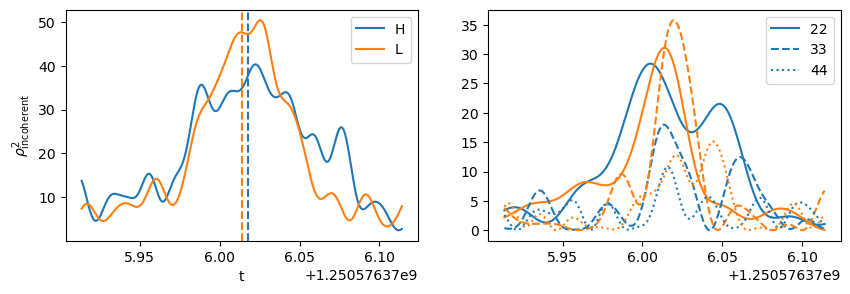

In [ ]:
plt.figure(figsize=(10,3))

plt.subplot(121)
plt.plot(times, 2*incoherent_lnprob_td[:,0], label='H'); plt.axvline(x=trig_h1[0], c='C0', ls='--')
plt.plot(times, 2*incoherent_lnprob_td[:,1],label='L'); plt.axvline(x=trig_h1[0]+tdiff, c='C1', ls='--')
# plt.axhline(y = np.max(2*incoherent_lnprob_td[:,1])-10)
plt.xlabel('t'); plt.ylabel(r'$\rho^2_\mathrm{incoherent}$'); plt.legend()

plt.subplot(122)
dh_mtd[:,:,0] /= dist_factor_h1; dh_mtd[:,:,1] /= dist_factor_l1
plt.plot(times,np.abs(dh_mtd[0])**2, label=['22',''])
plt.plot(times, (np.abs(dh_mtd[1])**2)[:,0], ls='--', color='C0', label='33')
plt.plot(times, (np.abs(dh_mtd[1])**2)[:,1], ls='--', color='C1')
plt.plot(times, (np.abs(dh_mtd[2])**2)[:,0], ls='dotted', color='C0', label='44')
plt.plot(times, (np.abs(dh_mtd[2])**2)[:,1], ls='dotted', color='C1')
plt.legend()
dh_mtd[:,:,0] *= dist_factor_h1; dh_mtd[:,:,1] *= dist_factor_l1

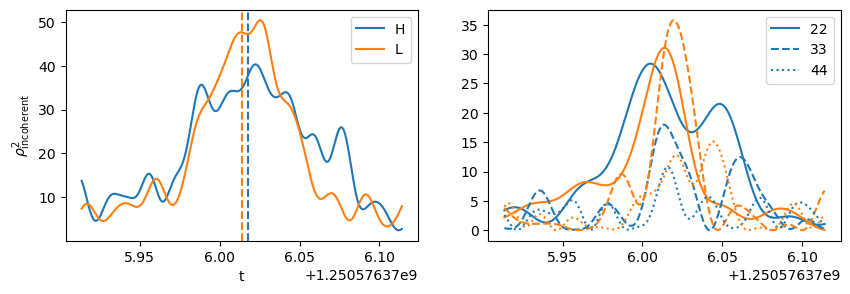

### Extra tests

In [ ]:
def gen_linestyles(number):
    """
    Return list of linestyles.

    Parameters
    ----------
    number: int
        How many linestyles are desired.
    """
    return [(0, (i**2+1, 1)) for i in range(number)]

def weighted_quantile(data, weights, quantile):
    """
    https://en.wikipedia.org/wiki/Percentile#The_weighted_percentile_method
    """
    order = np.argsort(data)
    data = data[order]
    weights = weights[order]
    cdf = np.cumsum(weights) / np.sum(weights)
    return np.interp(quantile, cdf, data)

def plot_qmc_adaptation(self, marg_info, times, tightness=.98):
    _, times = self.sky_dict.resample_timeseries(times, times)
    t_det = np.vstack((marg_info.t_first_det,
                       marg_info.t_first_det
                       + self.sky_dict.delays[:, marg_info.sky_inds]))
    norm = plt.Normalize(vmin=0, vmax=len(marg_info.proposals)-1)

    for i_det, detector_name in enumerate(self.sky_dict.detector_names): 
        plt.figure()
        plt.title(detector_name)

        tmin, tmax = weighted_quantile(t_det[i_det], marg_info.weights,
                                       (1-tightness, tightness))
        
        plt.hist(t_det[i_det], weights=marg_info.weights, bins=32,
                 density=True)
        lss = gen_linestyles(len(marg_info.proposals))

        for i, proposal in enumerate(marg_info.proposals):
            tmin_, tmax_ = weighted_quantile(
                times, proposal[i_det], (1-tightness, tightness))
            tmin = min(tmin, tmin_)
            tmax = max(tmax, tmax_)
            
            plt.plot(times,
                     proposal[i_det] / scipy.integrate.trapezoid(
                         proposal[i_det], times),
                     c=plt.cm.copper(norm(i)),
                     ls=lss[i])
        plt.xlim(tmin, tmax)
        plt.xlabel(r'Time (s)')
        
    plt.figure()
    plt.hist(self._qmc_sequence['psi'][marg_info.q_inds], weights=marg_info.weights, bins=32,
             density=True)
    plt.xlabel(r'$\psi$')

In [ ]:
cs_arr = []; neff=[]
for i in range(3):
    marg_info = cs_instance.get_marginalization_info(dh_mtd, hh_md, times, incoherent_lnprob_td, mode_ratios_qm)
    cs_arr.append(marg_info.lnl_marginalized)
    neff.append(marg_info.n_effective)

In [ ]:
# del
for i in range(3):
    cs_instance = cs.SearchCoherentScoreHMAS(
        sky_dict=cs.cogwheel.likelihood.marginalization.SkyDictionary(detectors[0][0]+detectors[1][0]),
                 log2n_qmc=log2n_qmc,nphi=nphi,max_log2n_qmc=max_log2n_qmc, n_qmc_sequences=128, seed=None)
    cs_instance.min_n_effective = min_n_effective
    marg_info = cs_instance.get_marginalization_info(dh_mtd, hh_md, times, incoherent_lnprob_td, mode_ratios_qm)
    print(marg_info.lnl_marginalized, marg_info.n_effective)

2.917452686635271 56.64319795287949
3.2880359762963085 52.67491885637158
3.601827292001222 53.04558869991244


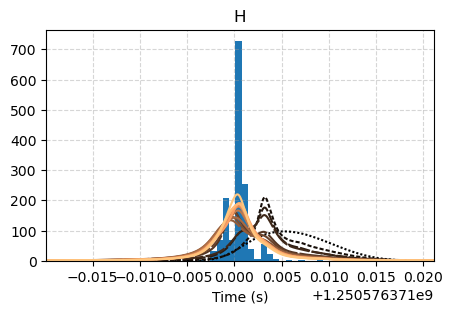

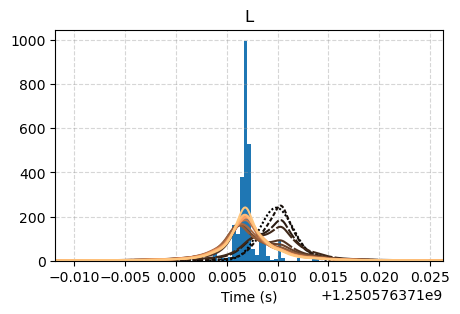

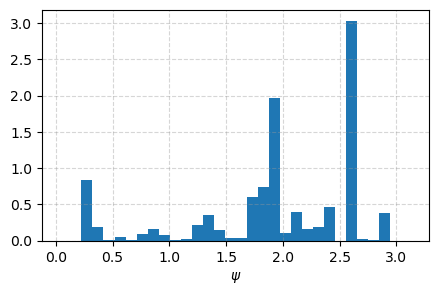

In [ ]:
plot_qmc_adaptation(cs_instance, marg_info, times)

### Comparison with 22 only

In [ ]:
coherent_scores_QAS = []
# timeseries = output['timeseries']
bg_events_22 = bg_events_all.copy()
bg_events_22[:,:,1] = bg_events_22[:,:,7]**2 + bg_events_22[:,:,8]**2

timeseries_22 = []
for i in range(len(timeseries)):
    timeseries_22.append((timeseries[i][0][:,:3],timeseries[i][1][:,:3]))

In [ ]:
detectors=('H1', 'L1'); detectors = tuple(sorted(detectors))
import coherent_score_mz_fast as cs22

In [ ]:
cs_instance22 = cs22.CoherentScoreMZ(
    samples_fname=cs22.DEFAULT_SAMPLES_FNAME[detectors], run='O3a')
# cs_instance22 = cs22.CoherentScoreMZ(
#     samples_fname=trashdir+'/del4_4096_1250576345.npz', detnames=detectors, run='O3a')

In [ ]:
cs_instance22.normfac_pos = 2
cs_instance22.hole_correction_pos = 3
cs_instance22.psd_drift_pos = 6
cs_instance22.rezpos = 7
cs_instance22.imzpos = 8
cs_instance22.c0_pos = 13

In [ ]:
# Compute coherent score integrals with ref_normfac=1
prior_terms, *_ = cs_instance22.get_all_prior_terms(
    bg_events_22, timeseries_22, time_slide_jump=0.1)

# Retain the integral terms
coherent_scores_22 = prior_terms[:, 0]

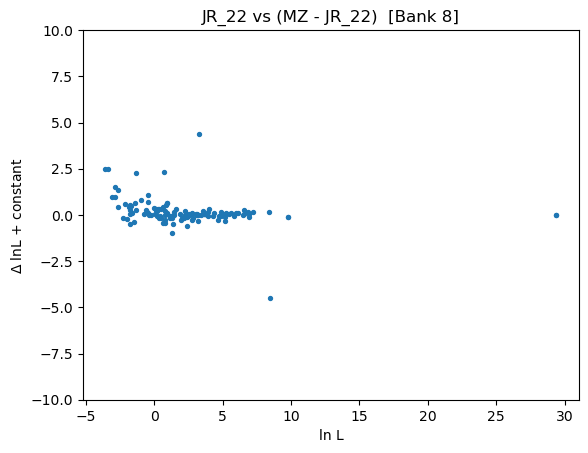

In [ ]:
plt.scatter(np.array(coherent_scores), coherent_scores_22/2-np.array(coherent_scores)-9,s=8)
# plt.scatter(np.array(coherent_scores)[-1], coherent_scores_22[-1]/2-np.array(coherent_scores[-1])-10,s=8)
plt.ylim(bottom=-10, top=10)
# plt.xlabel(r'Coh score JR (weights for HM=0)'); plt.ylabel('Coh score MZ (for 22)'); #plt.title('Bank-16,0')
plt.xlabel('ln L'); plt.ylabel('$\Delta$ lnL + constant'); plt.title(f'JR_22 vs (MZ - JR_22)  [Bank {ib}]');

### Comparing samples

In [ ]:
import corner
import pandas as pd

In [ ]:
psamples = cs22.pdic['psamples'].copy()

In [ ]:
# psamples = cs22.pdic['psamples']
psamples = psamples[:cs22.pdic['nsamp_phys']]
psamples[:,2] = cs_instance22.ra_grid[psamples[:,2].astype(int)]
psamples[:,3] = cs_instance22.dec_grid[psamples[:,3].astype(int)]

In [ ]:
weights = psamples[:,-1]/np.sum(psamples[:,-1])
np.sum(weights)**2 / np.sum(weights**2)/len(psamples) # Neff/ N

0.012269427215131178

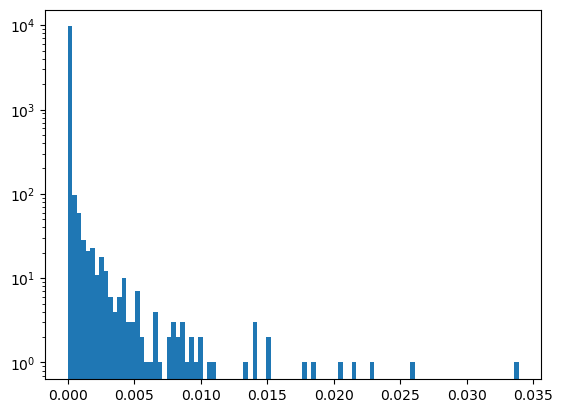

In [ ]:
plt.hist(weights, log=True,bins=100);

In [ ]:
psamples_gw_plot = pd.DataFrame(psamples, columns=['t_H','t_L','ra','dec','cosiota','psi','weights'])
psamples_gw_plot['psi'] %= np.pi

In [ ]:
from cogwheel import gw_plotting

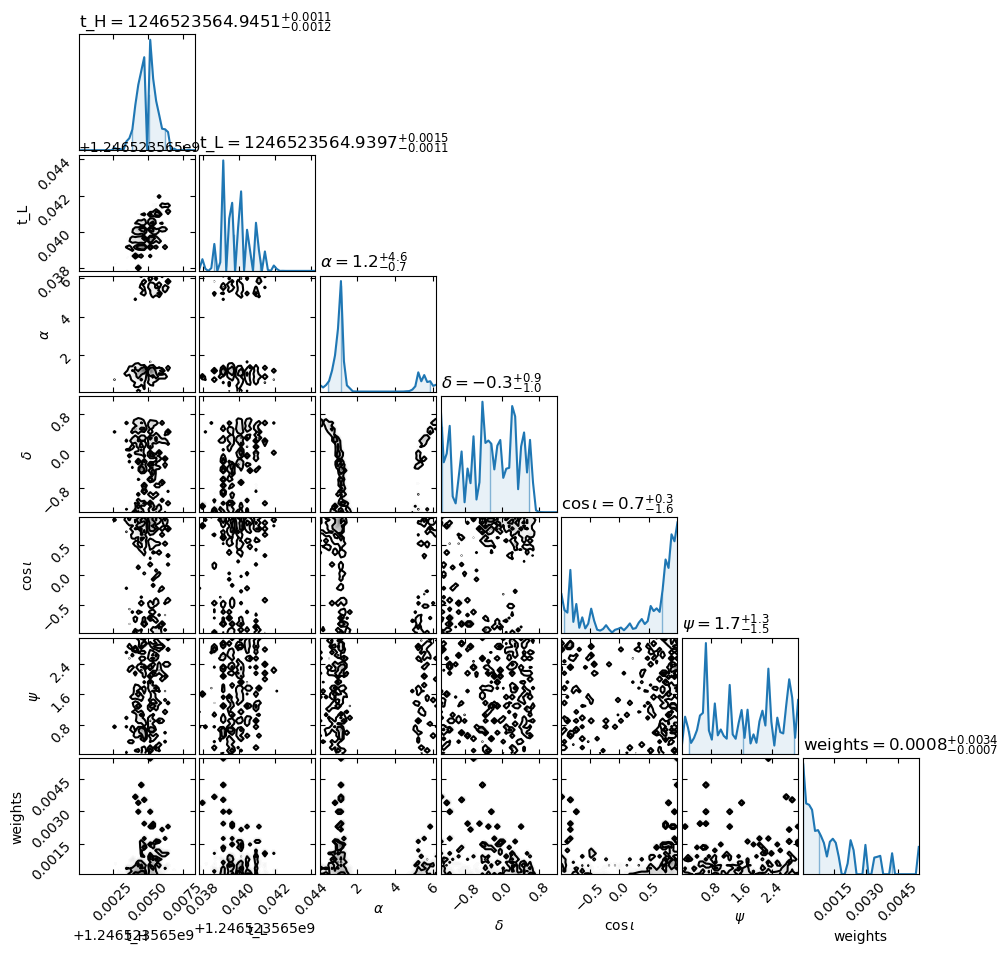

In [ ]:
gw_plotting.CornerPlot(psamples_gw_plot, weights = psamples_gw_plot['weights']).plot()

In [ ]:
def _gen_samples_from_marg_info(self, marg_info, num):  # `self` is a CS
    """
    Generate requested number of extrinsic parameter samples.

    Parameters
    ----------
    marg_info: MarginalizationInfoHM
        Output of ``.get_marginalization_info``.

    num: int, optional
        Number of samples to generate, defaults to a single sample.

    Return
    ------
    samples: dict
        Values are scalar if `num` is ``None``, else numpy arrays.
        If ``marg_info`` correspond to an unphysical sample (i.e.,
        a realization of matched-filtering timeseries in the
        detectors incompatible with a real signal) the values will
        be NaN.
    """
    if marg_info.q_inds.size == 0:
        return dict.fromkeys(['d_luminosity', 'dec', 'lon', 'phi_ref',
                              'psi', 't_geocenter', 'lnl_marginalized',
                              'lnl', 'h_h', 'n_effective', 'n_qmc'],
                             np.full(num, np.nan)[()])

    random_ids = self._rng.choice(len(marg_info.q_inds), size=num,
                                  p=marg_info.weights)

    q_ids = marg_info.q_inds[random_ids]
    o_ids = marg_info.o_inds[random_ids]
    sky_ids = marg_info.sky_inds[random_ids]
    t_geocenter = (marg_info.t_first_det[random_ids]
                   - self.sky_dict.geocenter_delay_first_det[sky_ids])
    d_h = marg_info.d_h[random_ids]
    h_h = marg_info.h_h[random_ids]

    d_luminosity = self._sample_distance(d_h, h_h)
    distance_ratio = d_luminosity / self.lookup_table.REFERENCE_DISTANCE
    return {
        'd_luminosity': d_luminosity,
        'dec': self.sky_dict.sky_samples['lat'][sky_ids],
        'lon': self.sky_dict.sky_samples['lon'][sky_ids],
        'phi_ref': self._phi_ref[o_ids],
        'psi': self._qmc_sequence['psi'][q_ids],
        't_geocenter': t_geocenter,
        'lnl_marginalized': np.full(num, marg_info.lnl_marginalized)[()],
        'lnl': d_h / distance_ratio - h_h / distance_ratio**2 / 2,
        'h_h': h_h / distance_ratio**2,
        'n_effective': np.full(num, marg_info.n_effective)[()],
        'n_qmc': np.full(num, marg_info.n_qmc)[()],
        'cosiota': self._qmc_sequence['cosiota'][q_ids],
        }

samples_list = []
for i in range(20):
    marg_info = cs_instance._get_marginalization_info(dh_mtd, hh_md,
                            times, incoherent_lnprob_td, mode_ratios_qm)
    samples_list.append(pd.DataFrame(_gen_samples_from_marg_info(cs_instance, marg_info, 1000)))
samples = pd.concat(samples_list)

# samples_list_QAS = []
# for i in range(20):
#     marg_info = cs_instance_QAS._get_marginalization_info(dh_mtd[0], hh_md[0].real, times)
#     samples_list_QAS.append(pd.DataFrame(cs_instance_QAS._gen_samples_from_marg_info(marg_info, 1000)))
# samples_QAS = pd.concat(samples_list_QAS)

AttributeError: 'SearchCoherentScoreHMAS' object has no attribute '_get_marginalization_info'

In [ ]:
params_samples = ['dec',
 'ra',
 # 'phi_ref',
 'psi',
 't_H',
 't_L',         
 # 'lnl_marginalized',
 # 'lnl',
 # 'h_h',
 # 'n_effective',
 # 'n_qmc',
 'cosiota']

In [ ]:
from cogwheel import gw_utils
h_delay, l_delay = gw_utils.get_geocenter_delays('HL', samples['dec'], samples['lon'])
h_delay_QAS, l_delay_QAS = gw_utils.get_geocenter_delays('HL', samples_QAS['dec'], samples_QAS['lon'])
from cogwheel import skyloc_angles

In [ ]:
import lal
samples['t_H'] = samples['t_geocenter'] + h_delay
samples['t_L'] = samples['t_geocenter'] + l_delay
samples['ra'] = skyloc_angles.lon_to_ra(samples['lon'], lal.GreenwichMeanSiderealTime(bg_events_all[-1,0,0]))

samples_QAS['t_H'] = samples_QAS['t_geocenter'] + h_delay_QAS
samples_QAS['t_L'] = samples_QAS['t_geocenter'] + l_delay_QAS
samples_QAS['ra'] = skyloc_angles.lon_to_ra(samples_QAS['lon'], lal.GreenwichMeanSiderealTime(bg_events_all[-1,0,0]))
samples_QAS['cosiota'] = np.cos(samples_QAS['iota'])

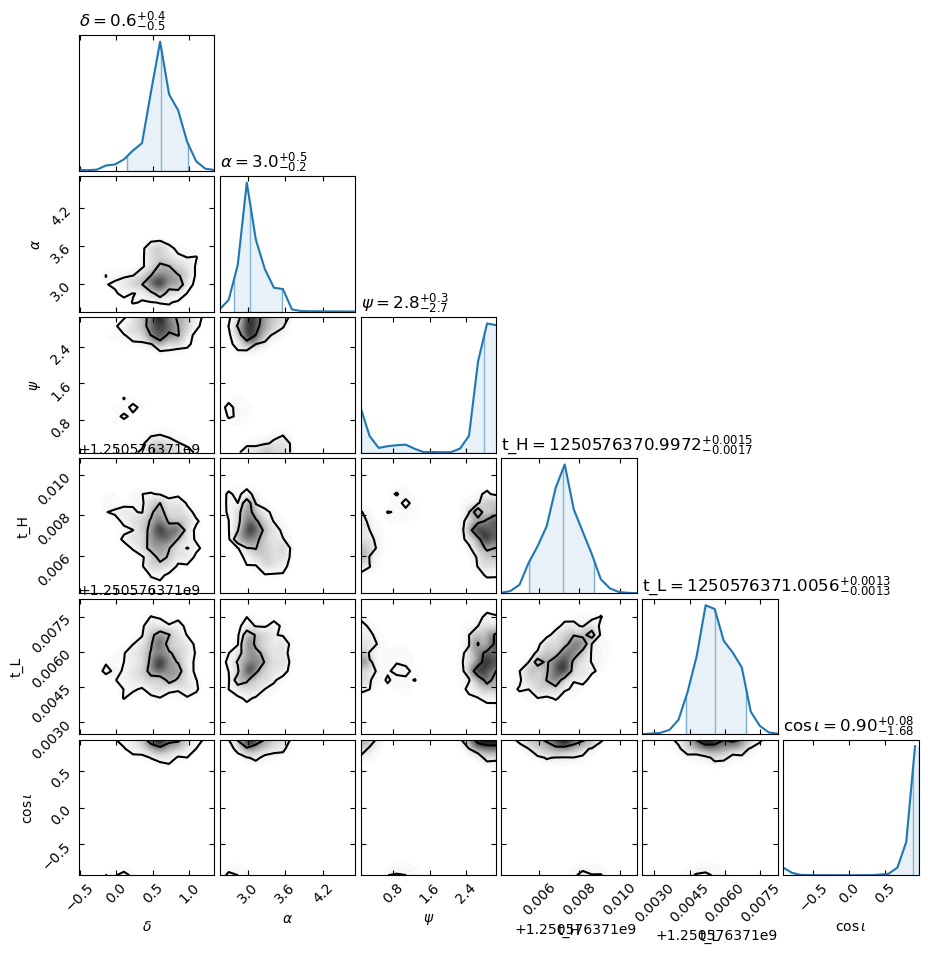

In [ ]:
from cogwheel import gw_plotting
samples = pd.DataFrame(samples)
gw_plotting.CornerPlot(samples[params_samples]).plot()

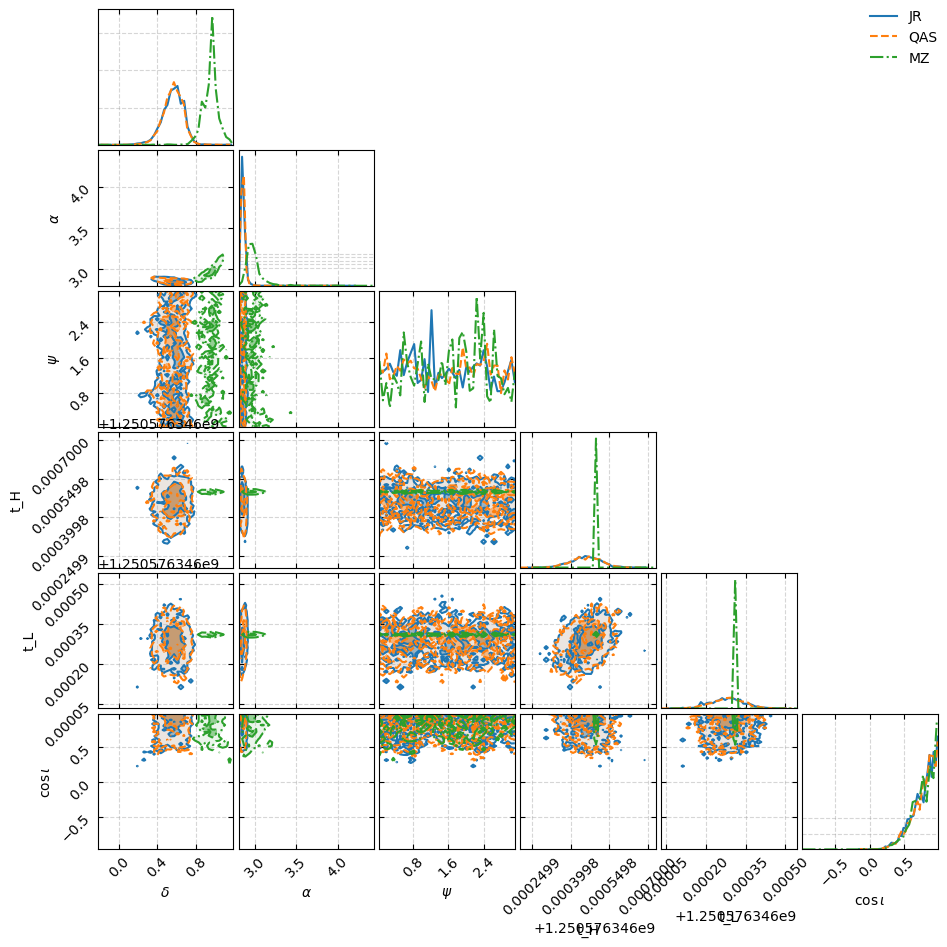

In [ ]:
samples = pd.DataFrame(samples)
samples_QAS = pd.DataFrame(samples_QAS)
gw_plotting.MultiCornerPlot([samples, samples_QAS, psamples_gw_plot], params=params_samples,labels=['JR','QAS','MZ']).plot()

Text(0.5, 1.0, 'MZ1 vs (MZ2 - MZ1)')

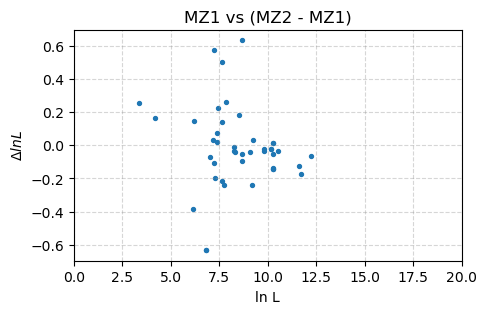

In [ ]:
# coherent_scores_22_old = coherent_scores_22.copy()
plt.scatter(coherent_scores_22/2, (coherent_scores_22 - coherent_scores_22_old)/2, s=8)
plt.xlim(left=0,right=20)
plt.xlabel('ln L'); plt.ylabel('$\Delta lnL$'); plt.title('MZ1 vs (MZ2 - MZ1)')

# Paper plots

In [26]:
import matplotlib as mpl
# Function for changing settings while making plots for paper
# useful as usetex settings are sometimes expensive
plt.rcParams["axes.grid"]=True;plt.rcParams["grid.alpha"]=0.4; 
plt.rcParams["grid.color"]='#999999'; plt.rcParams["grid.linestyle"]='--'

def mpl_settings(settings):
    if (settings=='default'):
        mpl.rc('text', usetex=False)
        mpl.rcParams['legend.fontsize'] = 'medium'
        plt.rcParams["xtick.labelsize"] = 'medium'
        plt.rcParams["ytick.labelsize"] = 'medium'
        plt.rcParams['axes.labelsize'] = 'medium'
        plt.rcParams['axes.titlesize']='large'
        plt.rcParams["figure.figsize"] = [5.0, 3.0]
        plt.rcParams["legend.fontsize"]='medium'
    elif(settings=='paper'):
        mpl.rc('text', usetex=True)
        plt.rcParams["figure.figsize"] = [5.0, 3.0]
        plt.rcParams["xtick.labelsize"] = 13; plt.rcParams["ytick.labelsize"] = 13
        plt.rcParams['axes.labelsize']=15
        plt.rcParams['axes.titlesize']=15
        plt.rcParams["legend.fontsize"]=17
        plt.rcParams["figure.titlesize"]=17

In [27]:
mpl_settings('paper')

(-10.0, 40.0)

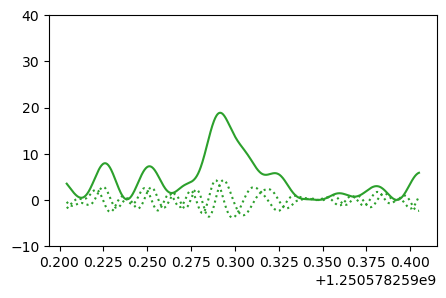

In [ ]:
# dh_mtd /= dist_factor
mode=1
plt.plot(times, np.abs(dh_mtd[mode,:,1])**2, color='C2');
plt.plot(times, np.real(dh_mtd[mode,:,1]), color='C2',ls='dotted',alpha=1);
plt.plot(times, np.imag(dh_mtd[mode,:,1]), color='C2',ls='dotted',alpha=1);

# Combining all modes
# plt.plot(times, np.abs(dh_mtd[0,:,1])**2+np.abs(dh_mtd[1,:,1])**2+np.abs(dh_mtd[2,:,1])**2, color='k');
plt.ylim(bottom=-10, top=40);

In [103]:
file_ind = 1243619328; detector='L1'; 
# file_ind = 1240793088; detector='H1';

run = 'O3a'
dname = '/data/jayw/IAS/GW/Data/PlotsPaper/Band_eraser/Before'
fpath = os.path.join(dname, f'{detector[0]}-{detector}_GWOSC_{run}_4KHZ_R1-{file_ind}-4096_config.json')
trigObj = trig.TriggerList.from_json(fpath)

dname = '/data/jayw/IAS/GW/Data/PlotsPaper/Band_eraser/After'
fpath = os.path.join(dname, f'{detector[0]}-{detector}_GWOSC_{run}_4KHZ_R1-{file_ind}-4096_config.json')
trigObj2 = trig.TriggerList.from_json(fpath)

Text(0.5, 1.0, 'H-H1_GWOSC_O3a_4KHZ_R1-1240793088-4096')

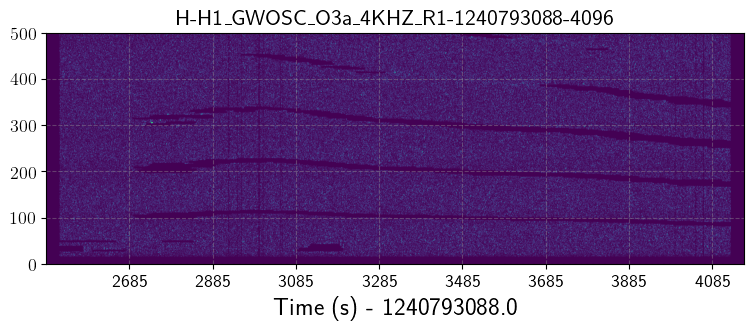

In [91]:
fig, ax = plt.subplots(figsize=(9,3))
trigObj2.specgram(ax=ax);
ax.set_ylim(top=500)
ax.set_xlabel(f"Time (s) - {trigObj.t0}", fontsize=18)
ax.set_ylabel('')
ax.set_title(
            os.path.splitext(os.path.basename(trigObj.fname))[0],
            fontsize=16, fontweight="bold")
# plt.savefig(plotdir+'trash.pdf', bbox_inches='tight');

Text(0.5, 1.0, 'H-H1_GWOSC_O3a_4KHZ_R1-1240793088-4096')

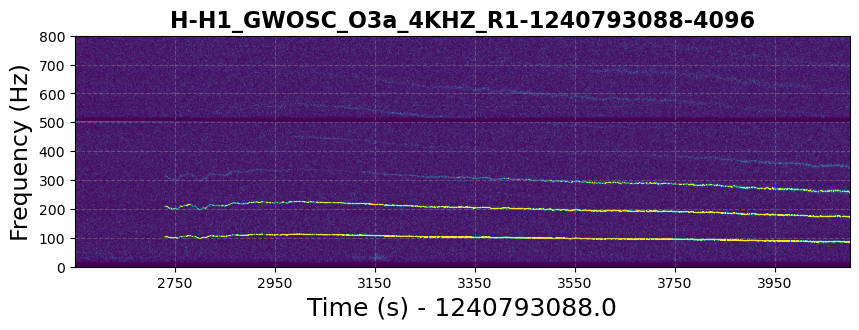

In [11]:
fig, ax = plt.subplots(figsize=(10,3))
trigObj.specgram(t0=trigObj.t0, ax=ax, tmin=2550, tmax=4100);
ax.set_ylim(top=800)
ax.set_xlabel(f"Time (s) - {trigObj.t0}", fontsize=18)
ax.set_ylabel('Frequency (Hz)', fontsize=17)
ax.set_title(
            os.path.splitext(os.path.basename(trigObj.fname))[0],
            fontsize=16, fontweight="bold")
# plt.savefig(plotdir+'trash.pdf', bbox_inches='tight');

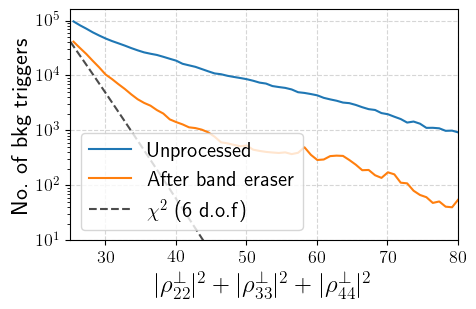

In [191]:
val0, bins = np.histogram(trigObj.processedclist[:,1], bins=100)
bincent = utils.bincent(bins)
val1, _ = np.histogram(trigObj2.processedclist[:,1], bins=bins)
plt.semilogy(bincent, val0, label='Unprocessed')
plt.semilogy(bincent, val1, label='After band eraser')
plt.ylabel('No. of bkg triggers', fontsize=17); 
plt.xlabel(r'$|\rho^\perp_{22}|^2+|\rho^\perp_{33}|^2+|\rho^\perp_{44}|^2$', fontsize=18);
plt.xlim(left=bins[0], right=80); plt.ylim(bottom=10)
plt.plot(bins[:-1],stats.chi2.pdf(bincent,6)/stats.chi2.pdf(bincent[0],6)*val1[0], ls='--',
          color='k', alpha=0.7,label='$\chi^2$ (6 d.o.f)')
plt.legend(fontsize=15)
plt.savefig(plotdir+'trash.pdf', bbox_inches='tight');

### HM Marginalized collection statistics

In [6]:
ib=14; isb=0
dire = '/data/jayw/IAS/GW/Data/PlotsPaper'
detector='H1'
run='O3a'
file_ind = 1250574336

In [7]:
fpath = os.path.join(dire, 'Physical_Scores', f'BBH_{ib}_bank_{isb}',
                      f'{detector[0]}-{detector}_GWOSC_{run}_4KHZ_R1-{file_ind}-4096_config.json')
trigObj = trig.TriggerList.from_json(fpath)
delta_calpha = trigObj.delta_calpha
# trigObj.threshold_chi2 = 25; trigObj.base_threshold_chi2 = 21

In [8]:
trigObj_marg  = copy.deepcopy(trigObj)
trigObj_unmarg = copy.deepcopy(trigObj)

In [9]:
trigObj_unmarg.processedclist = None
trigObj_unmarg.fname_preprocessing = None
trigObj_unmarg.trig_fname = None
trigObj_unmarg.nbankchunks_done=0
trigObj_unmarg.gen_triggers(delta_calpha=delta_calpha, marginalized_score_HM=False,ncores=10)

Number of bank chunks demanded now: 10
Number of bank chunks demanded previously: 1
Number of bank chunks do not match, restarting job to avoid repeated or missing waveforms
Saving 327732 new candidates


In [10]:
trigObj_marg.processedclist = None
trigObj_marg.fname_preprocessing = None
trigObj_marg.trig_fname = None
trigObj_marg.nbankchunks_done=0
trigObj_marg.gen_triggers(delta_calpha=delta_calpha, marginalized_score_HM=True,ncores=10)

Number of bank chunks demanded now: 10
Number of bank chunks demanded previously: 1
Number of bank chunks do not match, restarting job to avoid repeated or missing waveforms
Saving 22994 new candidates


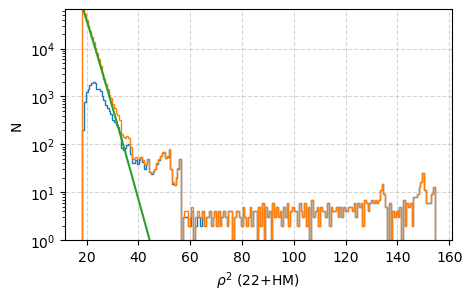

In [11]:
val , bins, _ = plt.hist(trigObj_marg.processedclist[:,1],log=True, bins=200,histtype='step')
val , _, _ = plt.hist(trigObj_unmarg.processedclist[:,1],log=True, bins=bins,histtype='step')
plt.ylabel('N'); plt.xlabel(r'$\rho^2$ (22+HM)'); #plt.title('Triggers');
bincent = utils.bincent(bins)
plt.plot(bincent,stats.chi2.pdf(bincent,6)/stats.chi2.pdf(bincent[0],6)*val[0])
plt.ylim(1,np.amax(val));

In [12]:
reload(tg)
# bank  = trigObj_unmarg.templatebank
bank = tg.TemplateBank.from_json(tbp.DIR + f'/BBH_{ib}/bank_{isb}/metadata.json')
bank.set_waveform_conditioning(2**18, 1/2048)

In [13]:
# Saving relevant data files for github notebook

# np.savez('/data/jayw/IAS/GW/Trash/Delete/data_for_statistics.npz',
#          times = trigObj_unmarg.processedclist[:,0],
#          rho_complex = trigObj_unmarg.processedclist[:,7:13].astype('float32'),
#          HM_amp_ratio_samples=trigObj_unmarg.templatebank.HM_amp_ratio_samples[0])

In [14]:
scores = trigObj_unmarg.processedclist[:,1]
marginalized_scores = bank.marginalized_HM_scores(trigObj_unmarg.processedclist,
                                                   marginalized=True, N_det_effective=2)
physical_scores = bank.marginalized_HM_scores(trigObj_unmarg.processedclist, marginalized=False)
physical_scores = np.linalg.norm(physical_scores, axis=-1)**2
scores_22 = np.linalg.norm(trigObj_unmarg.processedclist[:,7:9], axis=-1)**2

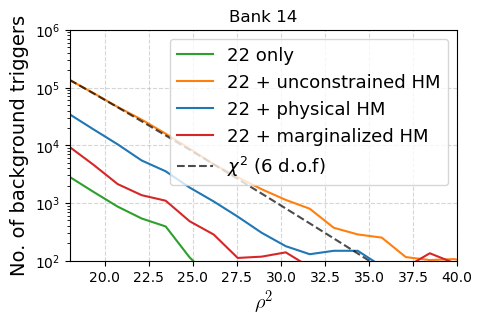

In [15]:
val0, bins = np.histogram(scores, bins=100); bincent = utils.bincent(bins)
val1,_ = np.histogram(scores_22, bins=bins)
val2,_ = np.histogram(physical_scores, bins=bins)
val3,_ = np.histogram(marginalized_scores, bins=bins)
plt.semilogy(bins[:-1],val1, label='22 only', color='C2')
plt.semilogy(bins[:-1],val0, label='22 + unconstrained HM', color='C1')
plt.semilogy(bins[:-1],val2, label='22 + physical HM', color='C0')
plt.semilogy(bins[:-1],val3, label='22 + marginalized HM', color='C3')
plt.plot(bins[:-1],stats.chi2.pdf(bincent,6)/stats.chi2.pdf(bincent[0],6)*val0[0], ls='--',
          color='k', alpha=0.7,label='$\chi^2$ (6 d.o.f)')
plt.ylabel('No. of background triggers', size=14); plt.xlabel(r'$\rho^2$',size=15,usetex=True);
# plt.xlim(left=25, right=50); plt.ylim(bottom=30, top=3e5);
plt.xlim(left=18, right=40); plt.ylim(bottom=100, top=1e6);
plt.legend(fontsize=13);
plt.title(f'Bank {ib}');
# plt.savefig('/data/jayw/CCA/Plots/trash.pdf', bbox_inches='tight')

In [16]:
binned = utils.splitarray(trigObj_unmarg.processedclist,trigObj_unmarg.processedclist[:,0],interval=.01)
scores_binned = np.array([x[np.random.choice(len(x))] for x in binned])
Z_binned = scores_binned[:,7:13:2] + 1j*scores_binned[:,8:13:2]

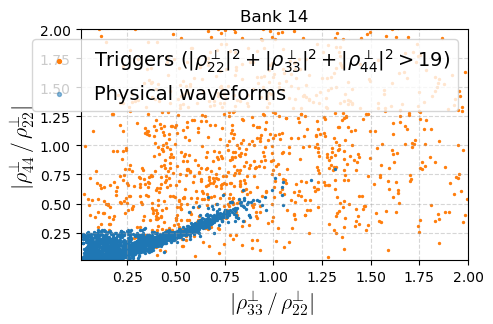

In [17]:
plt.scatter(np.abs(Z_binned[500:2000,1]/Z_binned[500:2000,0]),
             np.abs(Z_binned[500:2000,2]/Z_binned[500:2000,0]),s=2,color='C1', alpha=1)
plt.scatter(10,10,s=8,color='C1',
            label=r'Triggers ($|\rho^\perp_{22}|^2+|\rho^\perp_{33}|^2+|\rho^\perp_{44}|^2>19$)')
plt.scatter(bank.HM_amp_ratio_samples[0][:,0], bank.HM_amp_ratio_samples[0][:,1], s=2,color='C0')
plt.scatter(10,10,s=8,color='C0',label='Physical waveforms', alpha=0.5);
plt.legend(fontsize=14,loc=1);
plt.xlim(0.01,2);plt.ylim(0.01,2);
# plt.xscale('log'); plt.yscale('log');
plt.xlabel(r'$|\rho^\perp_{33}\, /\, \rho^\perp_{22}|$',size=16,usetex=True);
plt.ylabel(r'$|\rho^\perp_{44}\, /\, \rho^\perp_{22}|$',size=16, usetex=True);
plt.title(f'Bank {ib}');
# plt.savefig(plotdir+'trash.pdf', bbox_inches='tight');

# Old codes

In [ ]:
# delete below later, was used for time-profiling triggering

In [102]:
from cProfile import Profile

In [258]:
triggers_dir = '/data/jayw/IAS/GW/Data/HM_O3a_search/Triggers_single_det'
ib=0; isb=0
run='O3a'
detector = 'H1'
dname = os.path.join(triggers_dir,f'BBH_{ib}_bank_{isb}')
file_ind = 1250574336
# Sample file: O3a:1250574336 O3b:1269358592

In [277]:
fpath = os.path.join(dname, f'{detector[0]}-{detector}_GWOSC_{run}_4KHZ_R1-{file_ind}-4096_config.json')
trigObj = trig.TriggerList.from_json(fpath)
# trigObj = trig.TriggerList.from_json(fpath,load_data=True, do_signal_processing=False)

In [ ]:
with Profile() as profiler:

    trigObj.processedclist = None
    trigObj.fname_preprocessing = None
    trigObj.trig_fname = None
    trigObj.nbankchunks_done=0
    trigObj.base_threshold_chi2=23
    # trigObj.threshold_chi2=26
    trigObj.gen_triggers(delta_calpha=delta_calpha,
    marginalized_score_HM=True, ncores=1)

In [ ]:
profiler.print_stats('tottime')